# <font color='purple'>Cell pose QC statistics: cell count in tiles </font> 
## Nancy, May 17 2023


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
sns.color_palette("husl", 8)
plt.rcParams["image.cmap"] = "Set1"


In [2]:
##MOMAPS_HOME = os.getenv("MOMAPS_HOME") 
MOMAPS_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps' # because I'm running from Sagy's user
LOGS_PATH = os.path.join(MOMAPS_HOME, 'src', 'preprocessing', 'logs')
#LOGS_PATH = '/Users/nancy/PycharmProjects/MOmaps/logs'

In [3]:
files_pds = []

# Go over all files under logs
for file in os.listdir(LOGS_PATH):
    # Take only "cell_count_stats" CSV files
    if file.endswith(".csv") and file.startswith("cell_count_stats"):

        # Load each CSV
        df = pd.read_csv(os.path.join(LOGS_PATH,file), 
                         index_col=None, 
                         header=0, 
                         # NY: converters make the code slow...
                         #converters={'cells_counts': pd.eval, 'whole_cells_counts': pd.eval}
                        )
        
        ##print(file, df.shape) 
        
        # Combine them to a single dataframe
        if (not df.empty):
            files_pds.append(df)
            
print("\nTotal of", len(files_pds), "files were read.")



Total of 17 files were read.


In [4]:
all_df = pd.concat(files_pds, axis=0).reset_index()
print(all_df.shape)
#all_df.sample(50)

(96521, 20)


## Handle duplicates
### 9 lines * 11 panels * 200 DAPI images = ~19,800 DAPI images in batch

In [5]:
all_df['site_num'] = all_df.filename.str.split("_").str[-1]
#all_df.head()

In [6]:
# drop rows with duplicated "filename-batch-cellline-panel-site"  combination, but keep the row with max "cells_count_mean"
df_tmp = all_df.sort_values('cells_count_mean', ascending=False).drop_duplicates(subset=['filename','batch', 'cell_line', 'panel', 'condition', 'rep', 'marker'], 
                            keep='first',
                            inplace=False).sort_index()

print("After duplication removal #1:", df_tmp.shape)

# Now handle correpted duplicated rows (same batch-cellline-panel-site, but different file name)
_subset=['site_num', 'batch', 'cell_line', 'panel', 'condition', 'rep', 'marker', 
        'cells_counts', 'cells_count_mean', 'cells_count_std',
        'whole_cells_counts', 'whole_cells_count_mean', 'whole_cells_count_std',
        'n_valid_tiles', 'cells_count_in_valid_tiles_mean',
        'cells_count_in_valid_tiles_std',
        'whole_cells_count_in_valid_tiles_mean',
        'whole_cells_count_in_valid_tiles_std']


df = df_tmp.drop_duplicates(subset=_subset,inplace=False)

print("After duplication removal #2:", df.shape)
#df.head()

After duplication removal #1: (80466, 21)
After duplication removal #2: (78713, 21)



# <font color='red'>Number of sites in each batch and cellline </font>


<AxesSubplot:xlabel='batch', ylabel='count'>

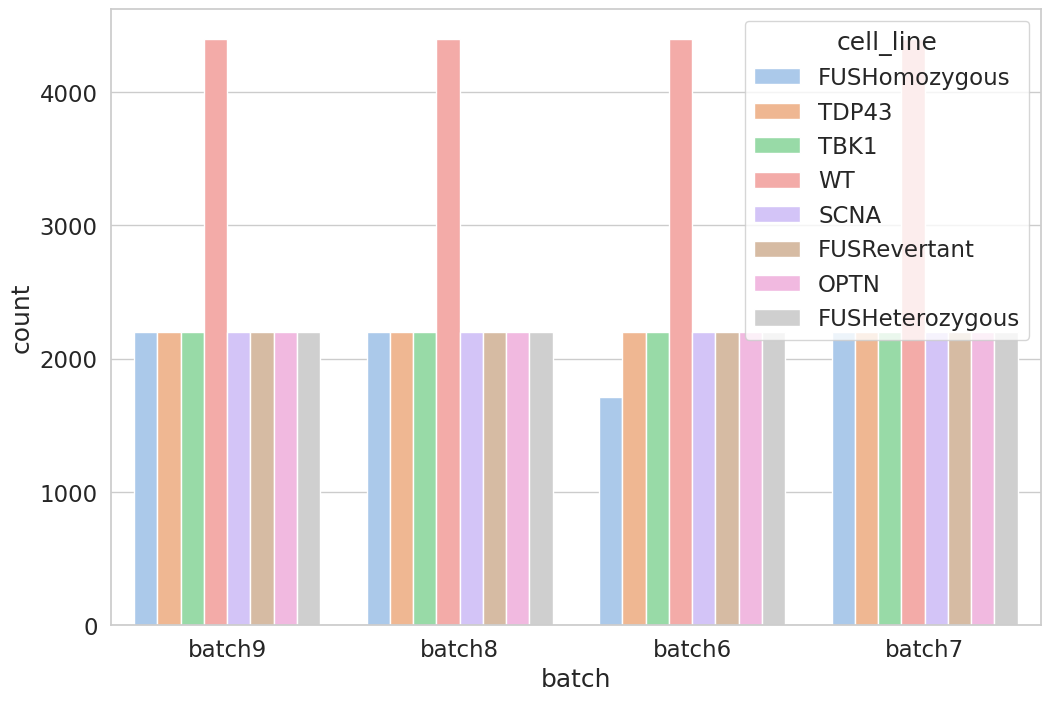

In [7]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='batch', hue='cell_line', palette=sns.color_palette('pastel'))


In [8]:
columns = ['batch', 'cell_line', 'panel', 'condition', 'rep', 'marker']

for col in columns:
    print("\nColumn", col, "has", df[col].nunique(), "unique values.\n" , df[col].value_counts().sort_values())


Column batch has 4 unique values.
 batch
batch6    19313
batch9    19800
batch8    19800
batch7    19800
Name: count, dtype: int64

Column cell_line has 8 unique values.
 cell_line
FUSHomozygous       8313
TDP43               8800
TBK1                8800
SCNA                8800
FUSRevertant        8800
OPTN                8800
FUSHeterozygous     8800
WT                 17600
Name: count, dtype: int64

Column panel has 11 unique values.
 panel
panelA    7154
panelE    7154
panelG    7154
panelI    7155
panelD    7156
panelK    7156
panelC    7156
panelB    7157
panelJ    7157
panelF    7157
panelH    7157
Name: count, dtype: int64

Column condition has 2 unique values.
 condition
stress        8800
Untreated    69913
Name: count, dtype: int64

Column rep has 2 unique values.
 rep
rep1    39113
rep2    39600
Name: count, dtype: int64

Column marker has 1 unique values.
 marker
DAPI    78713
Name: count, dtype: int64


In [9]:
pd.set_option('display.max_rows', 300)
combo_counts = df.groupby(['batch', 'cell_line', 'panel', 'condition', 'marker']).size().unstack(level=4)
combo_counts.columns = ['Number of processed sites']
combo_counts.head(300).sort_values(by='Number of processed sites').head(300)

Number of processed sites
batch  cell_line       panel  condition                           
batch6 FUSHomozygous   panelG Untreated                        154
                       panelA Untreated                        154
                       panelE Untreated                        154
                       panelI Untreated                        155
                       panelC Untreated                        156
                       panelK Untreated                        156
                       panelD Untreated                        156
                       panelJ Untreated                        157
                       panelH Untreated                        157
                       panelF Untreated                        157
                       panelB Untreated                        157
batch8 FUSHeterozygous panelI Untreated                        200
                       panelH Untreated                        200
                       panelG Untreated                        200
                       panelF Untreated                        200
batch6 FUSHeterozygous panelA Untreated                        200
batch8 FUSHeterozygous panelE Untreated                        200
                       panelD Untreated                        200
                       panelC Untreated                        200
                       panelB Untreated                        200
                       panelA Untreated                        200
batch7 WT              panelK stress                           200
                              Untreated                        200
                       panelJ stress                           200
                              Untreated                        200
                       panelI stress                           200
batch8 FUSHeterozygous panelJ Untreated                        200
                       panelK Untreated                        200
       FUSHomozygous   panelF Untreated                        200
                       panelB Untreated                        200
       FUSRevertant    panelE Untreated                        200
                       panelD Untreated                        200
                       panelC Untreated                        200
                       panelB Untreated                        200
                       panelA Untreated                        200
       FUSHomozygous   panelK Untreated                        200
                       panelA Untreated                        200
                       panelJ Untreated                        200
                       panelH Untreated                        200
                       panelG Untreated                        200
batch7 WT              panelI Untreated                        200
batch8 FUSHomozygous   panelE Untreated                        200
                       panelD Untreated                        200
                       panelC Untreated                        200
                       panelI Untreated                        200
batch7 WT              panelH stress                           200
                       panelE stress                           200
                       panelG stress                           200
       TDP43           panelF Untreated                        200
                       panelE Untreated                        200
                       panelD Untreated                        200
                       panelC Untreated                        200
                       panelB Untreated                        200
                       panelA Untreated                        200
                       panelG Untreated                        200
       TBK1            panelK Untreated                        200
                       panelI Untreated                        200
                       panelH Untreated                        200
                     

(19800, 21)


Text(0.5, 0, 'Number valid tiles at batch 8')

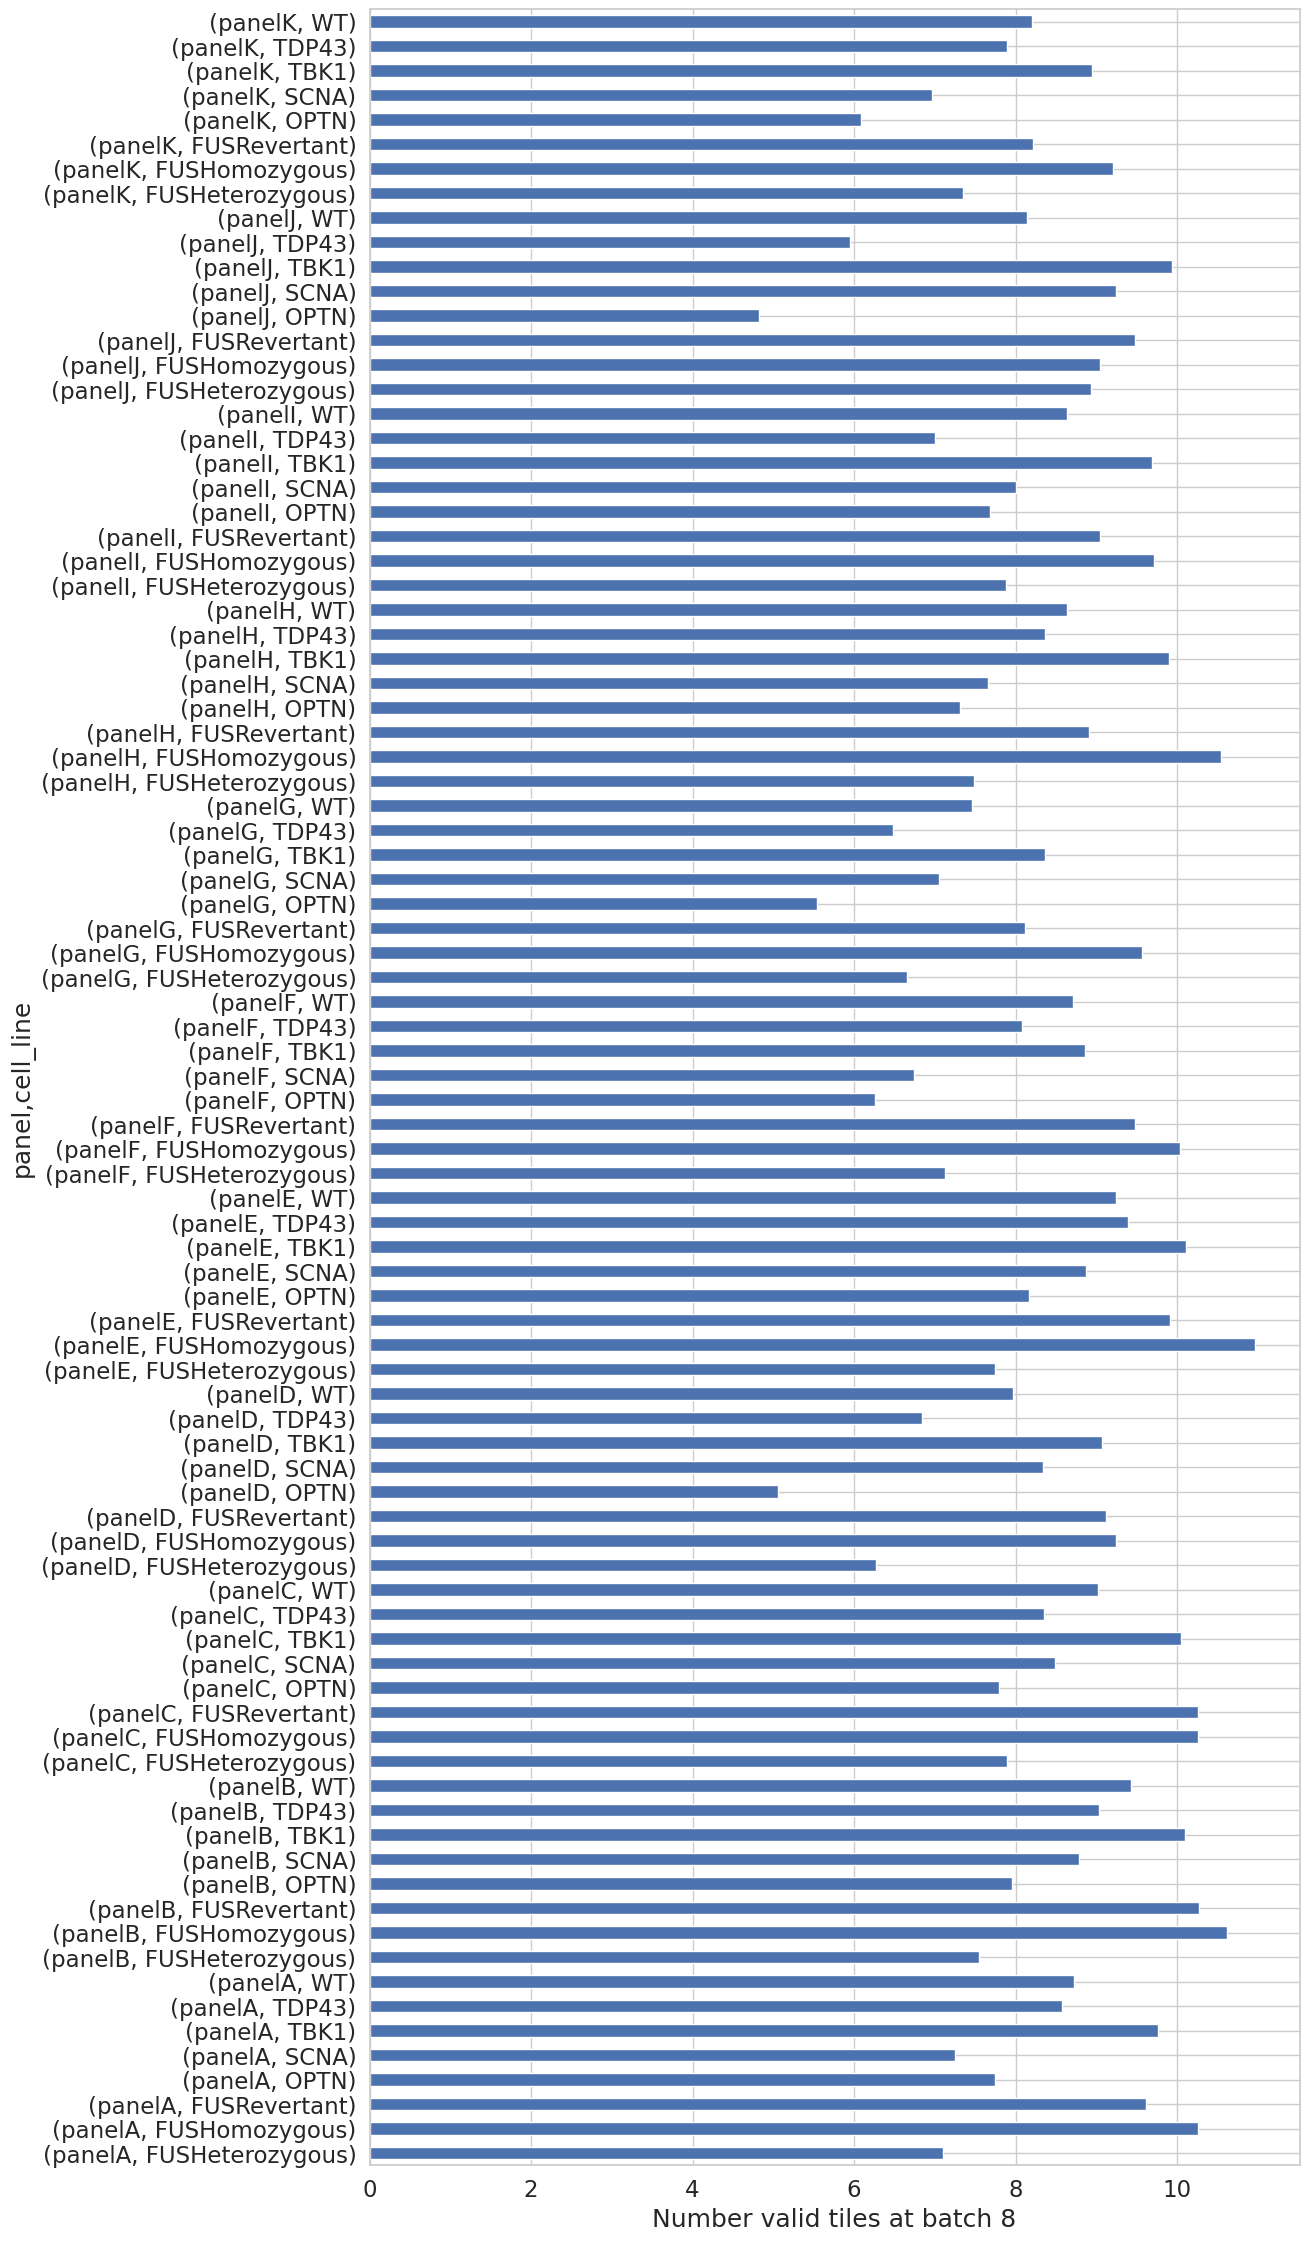

In [10]:
df_batch8 = df[df['batch']=='batch8']
print(df_batch8.shape)
##print(df_batch8[['panel', 'cell_line']].value_counts().sort_values())

plt.figure(figsize=(12,28))
g = df_batch8[['panel', 'cell_line','n_valid_tiles','condition', 'rep']].groupby(['panel', 'cell_line'])['n_valid_tiles'].mean()
g.plot.barh(stacked=True)
plt.xlabel("Number valid tiles at batch 8")


# <font color='blue'>Cell counts, whole cell counts and number of valid tiles </font>


<Figure size 800x800 with 0 Axes>

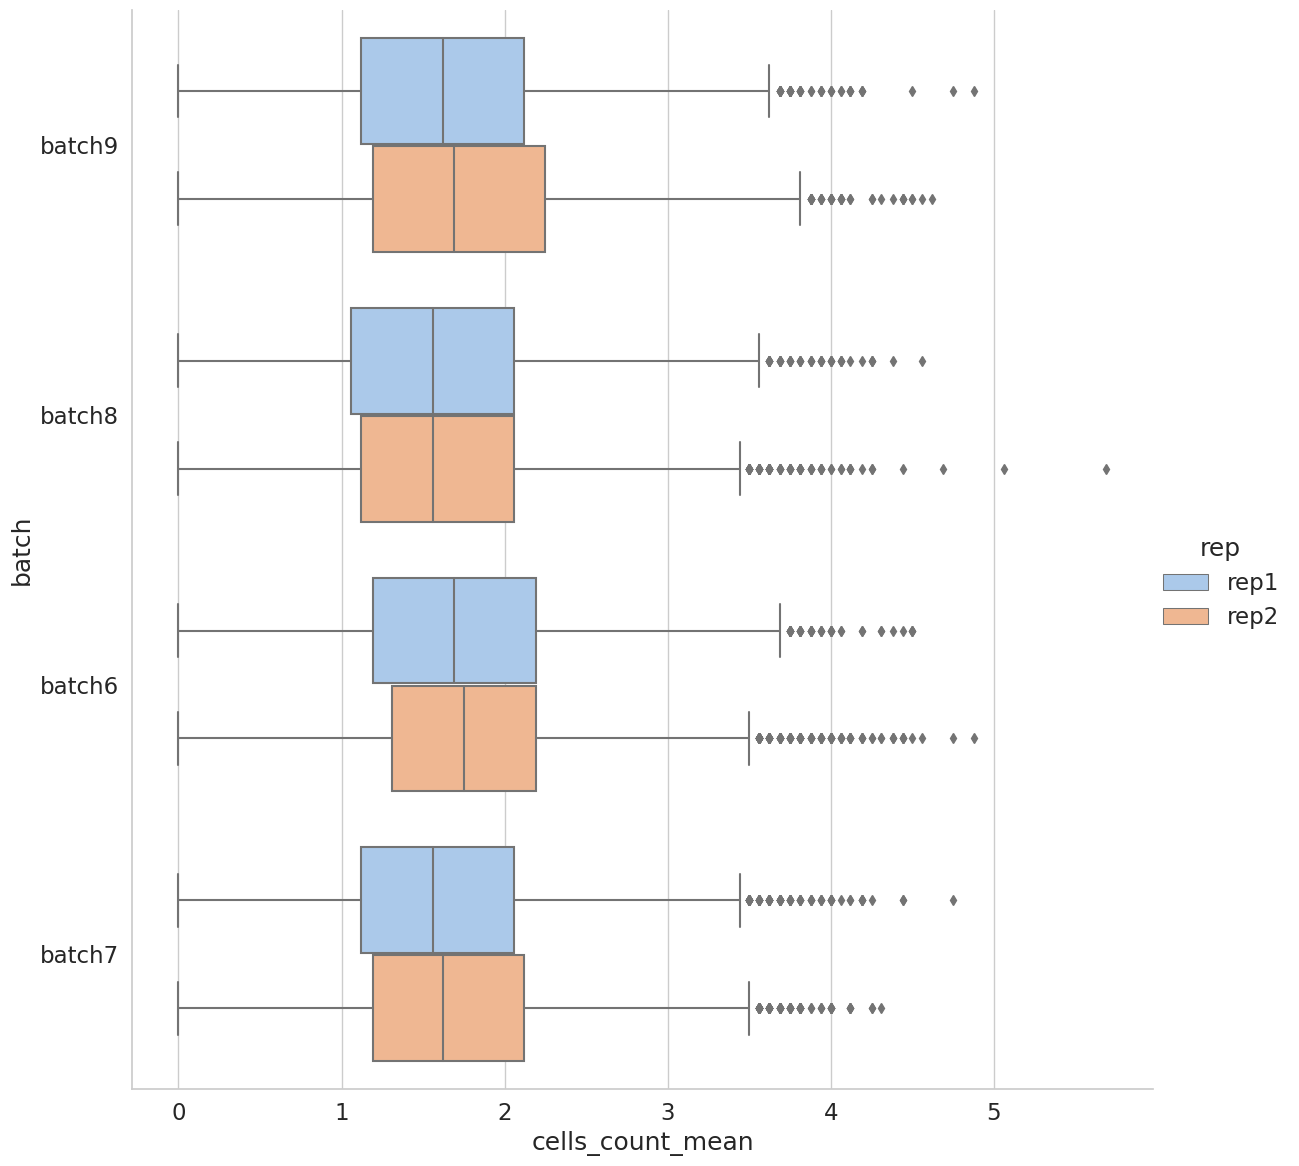

<Figure size 800x800 with 0 Axes>

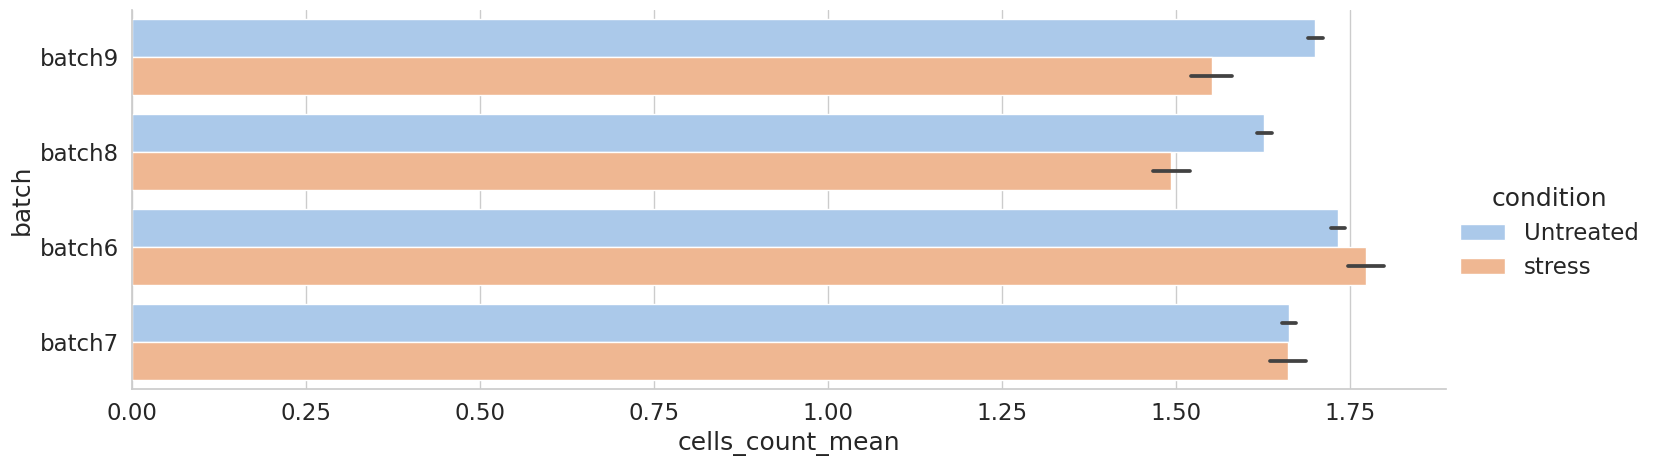

<Figure size 800x800 with 0 Axes>

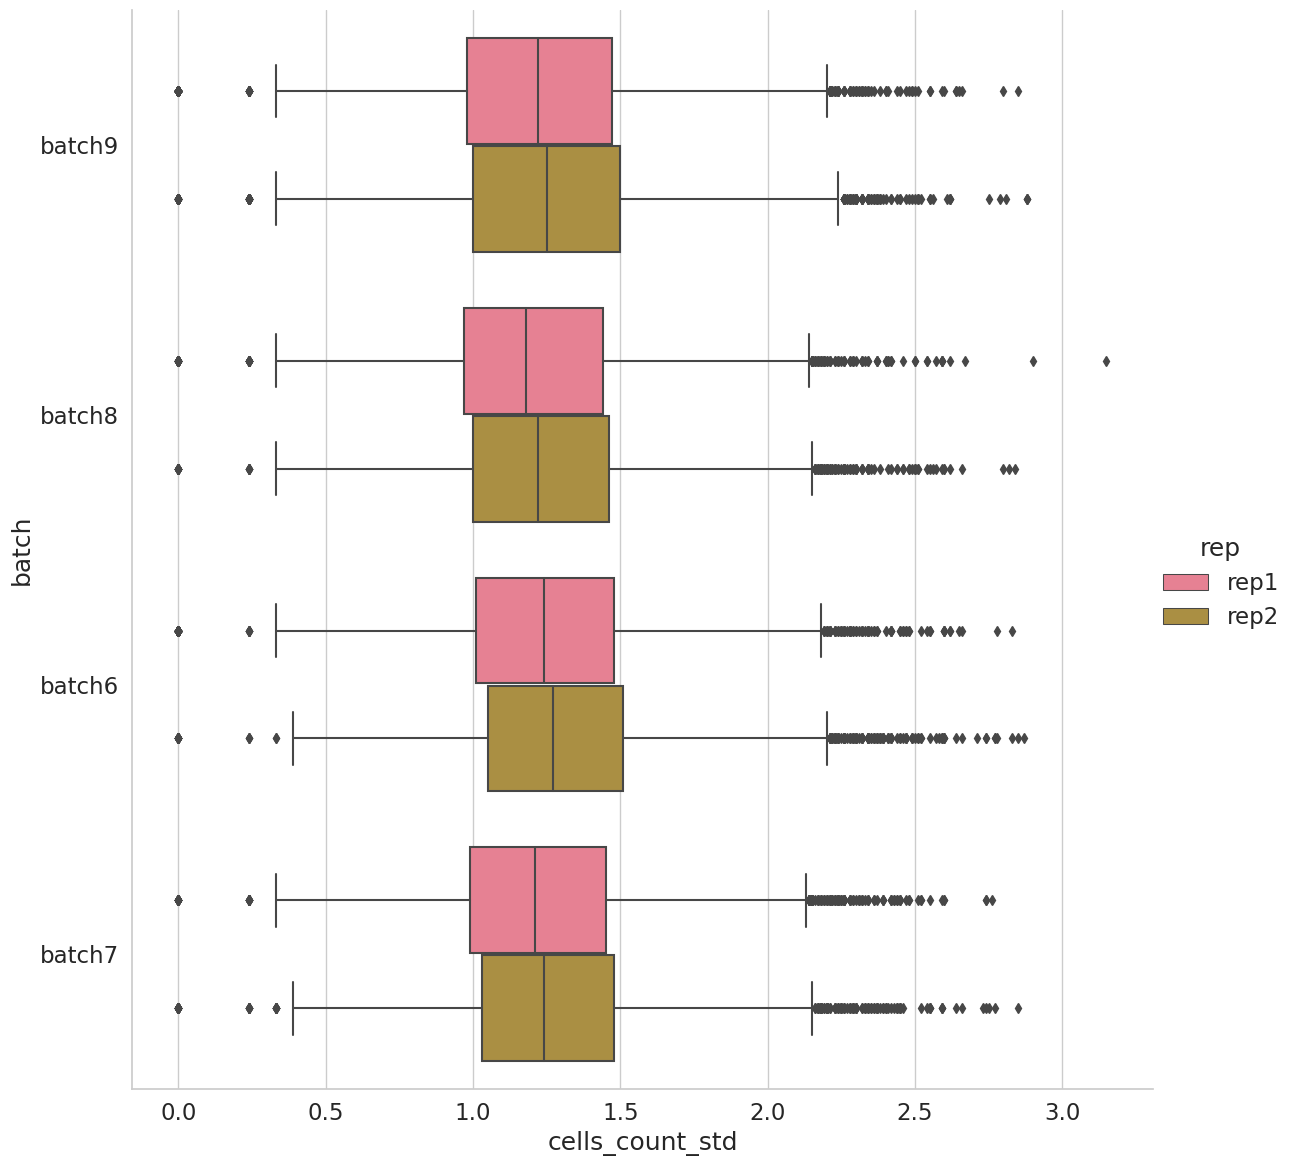

<Figure size 800x800 with 0 Axes>

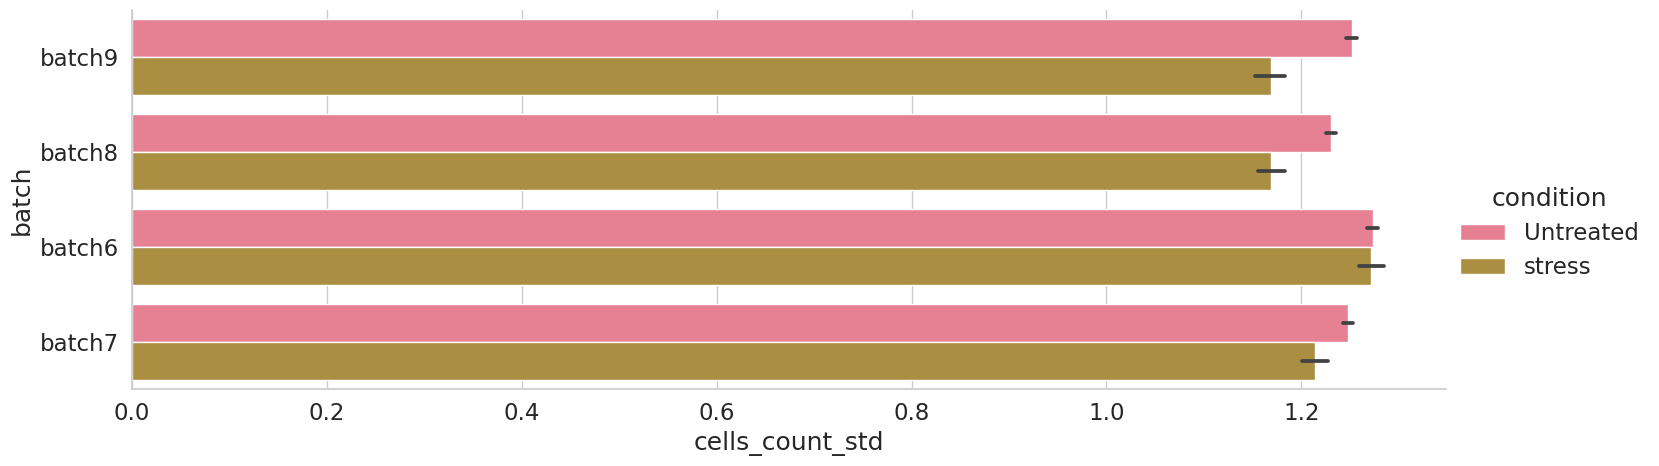

<Figure size 800x800 with 0 Axes>

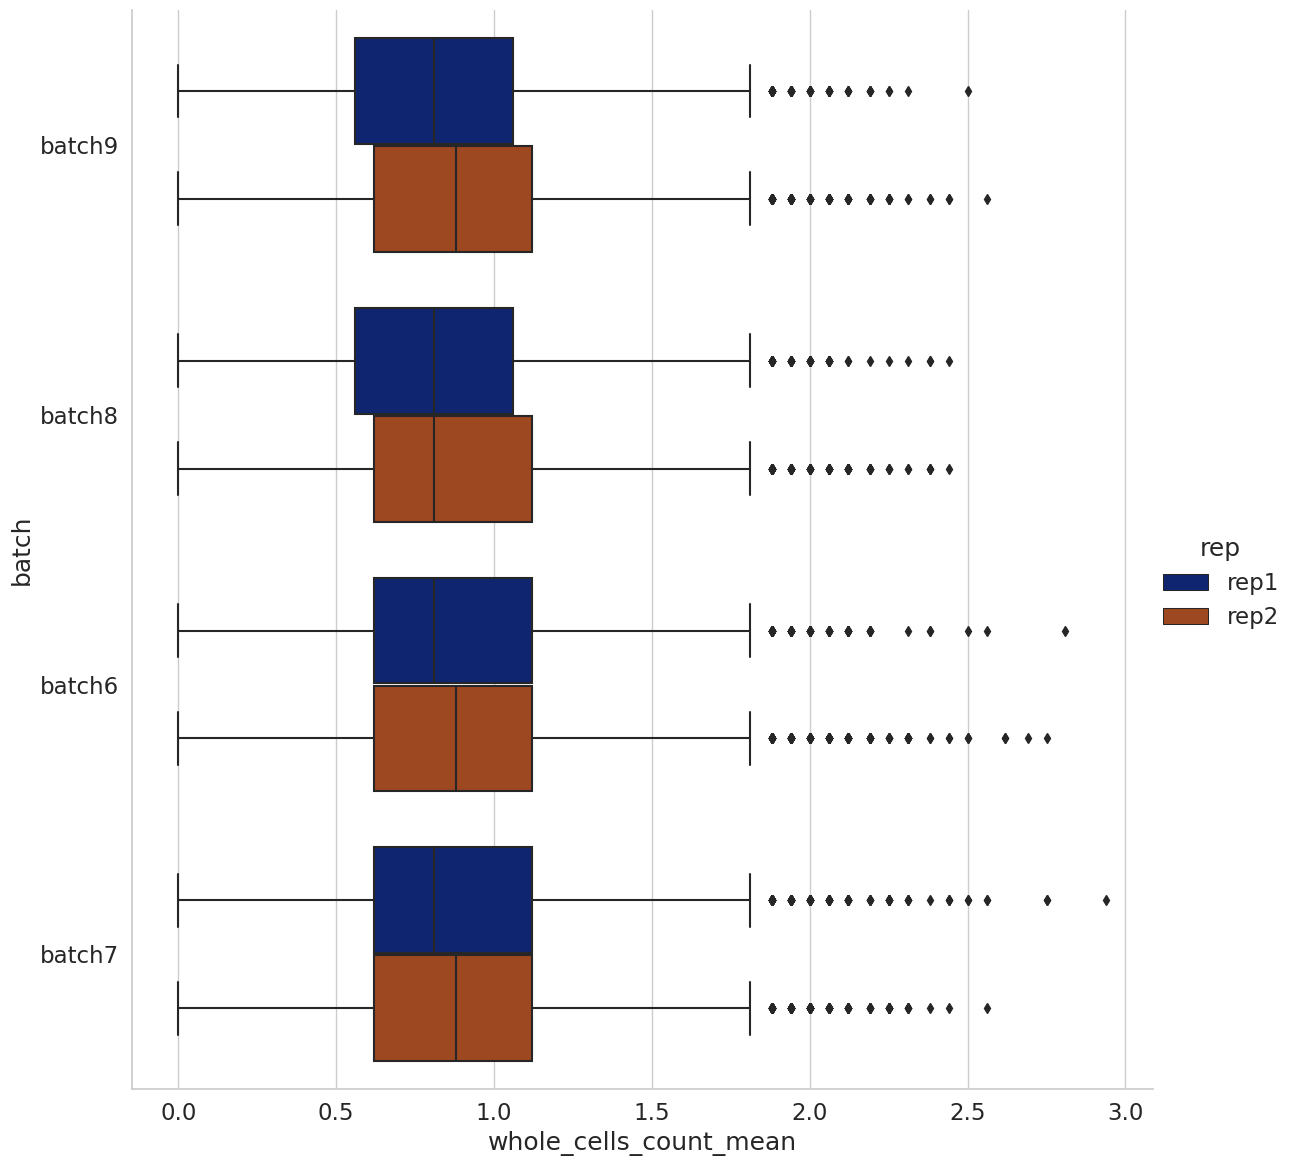

<Figure size 800x800 with 0 Axes>

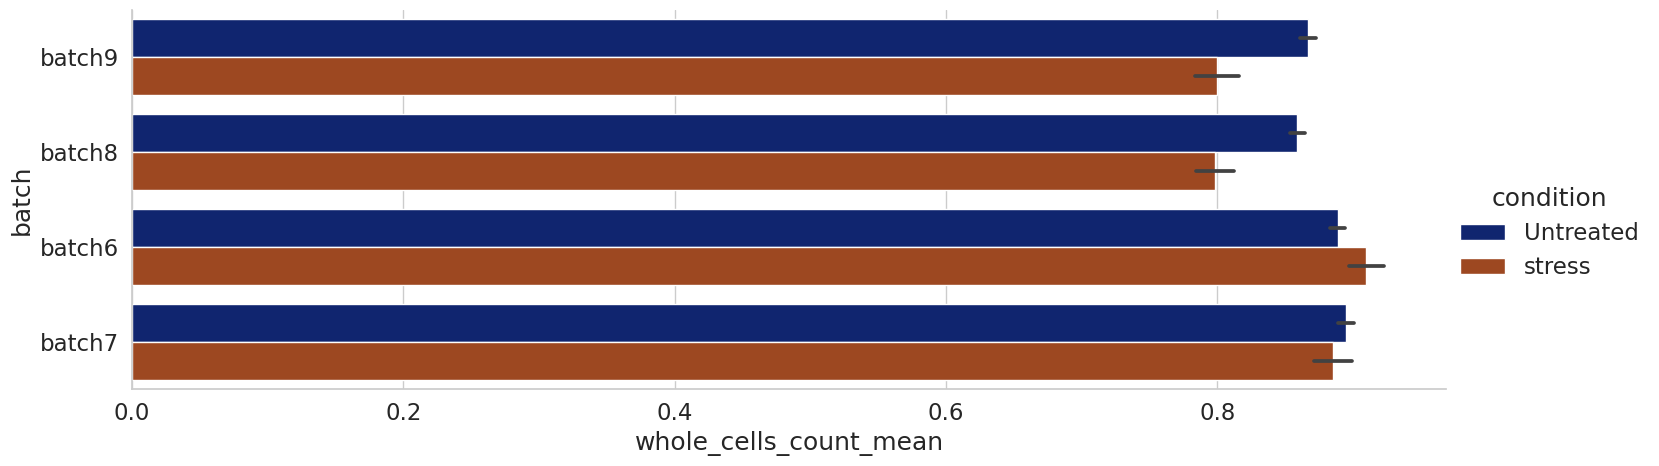

<Figure size 800x800 with 0 Axes>

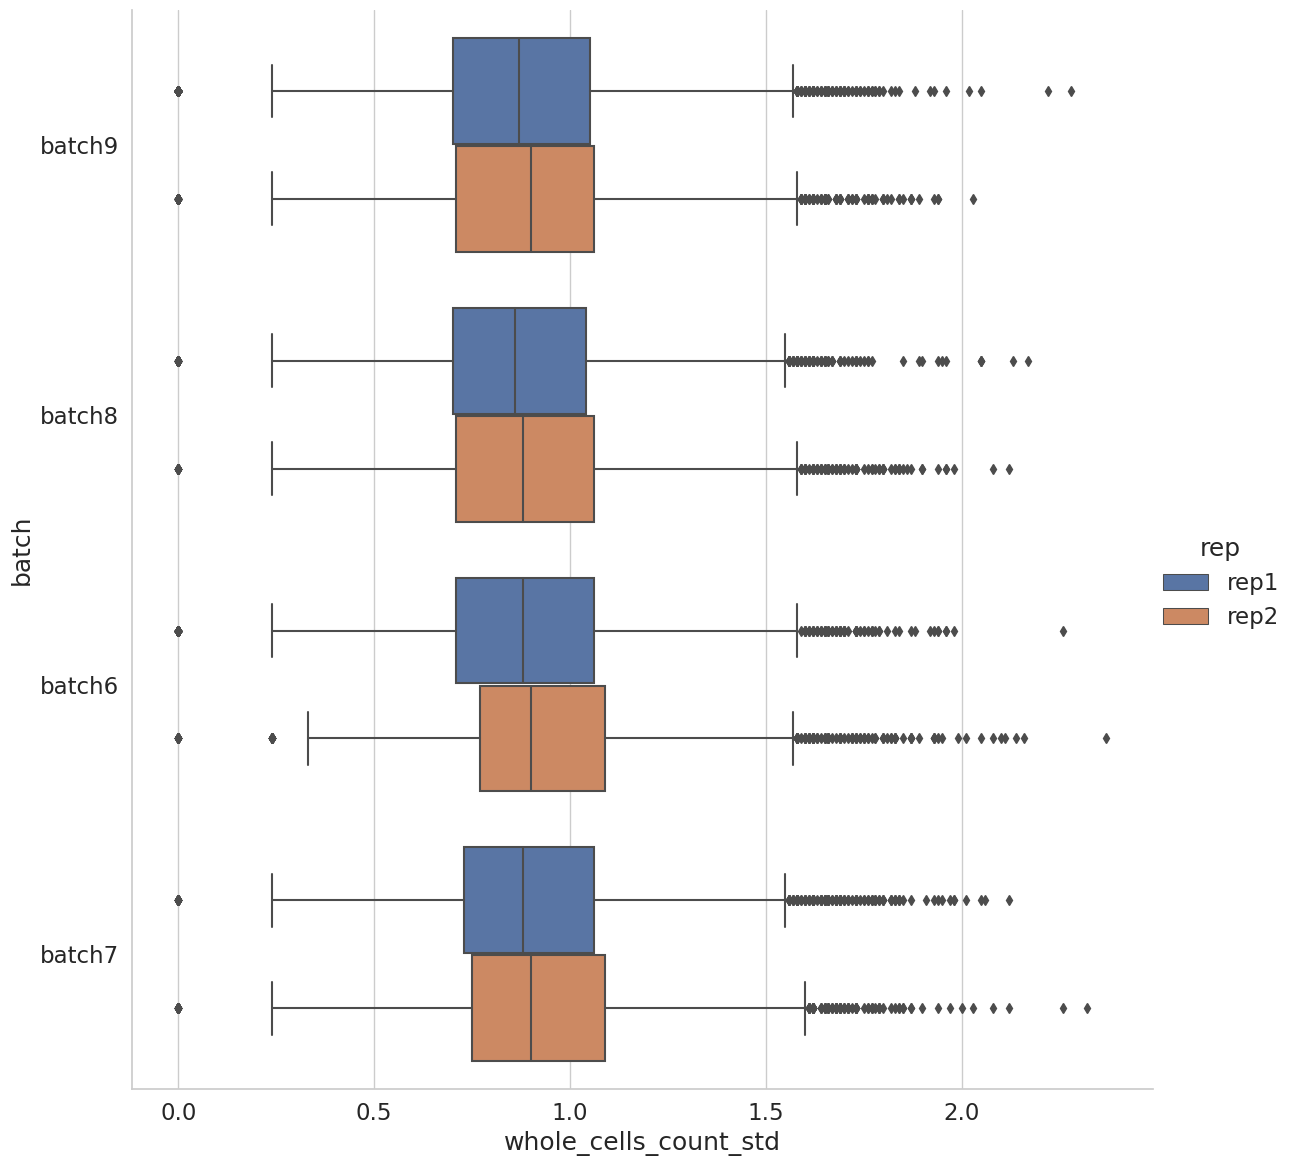

<Figure size 800x800 with 0 Axes>

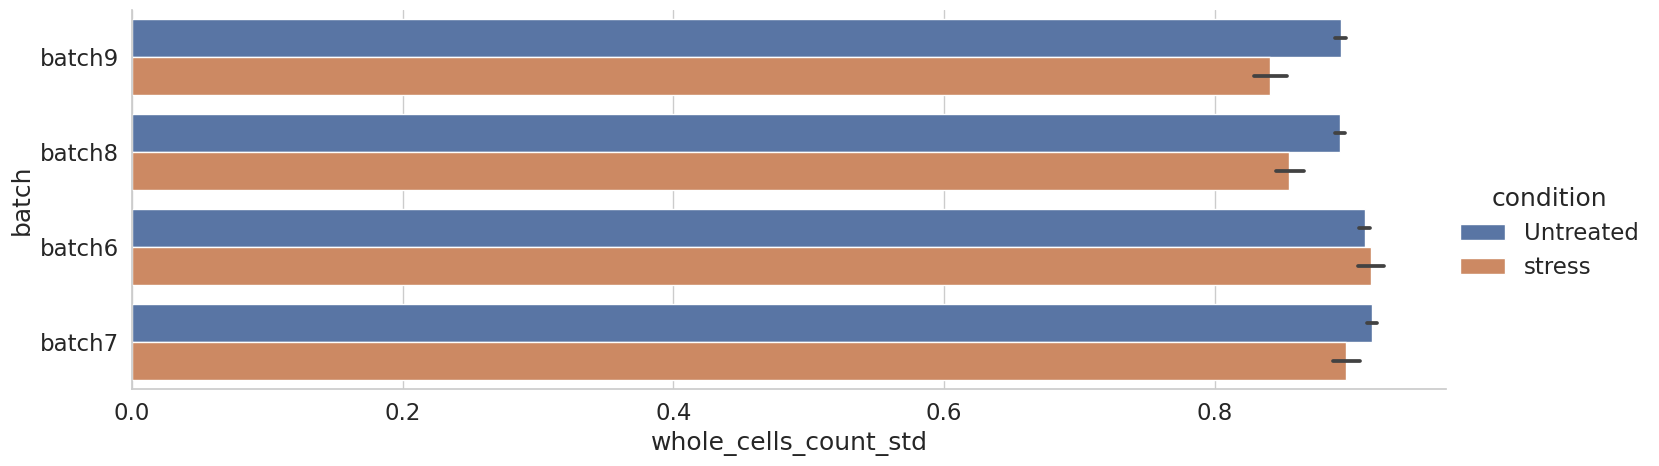

<Figure size 800x800 with 0 Axes>

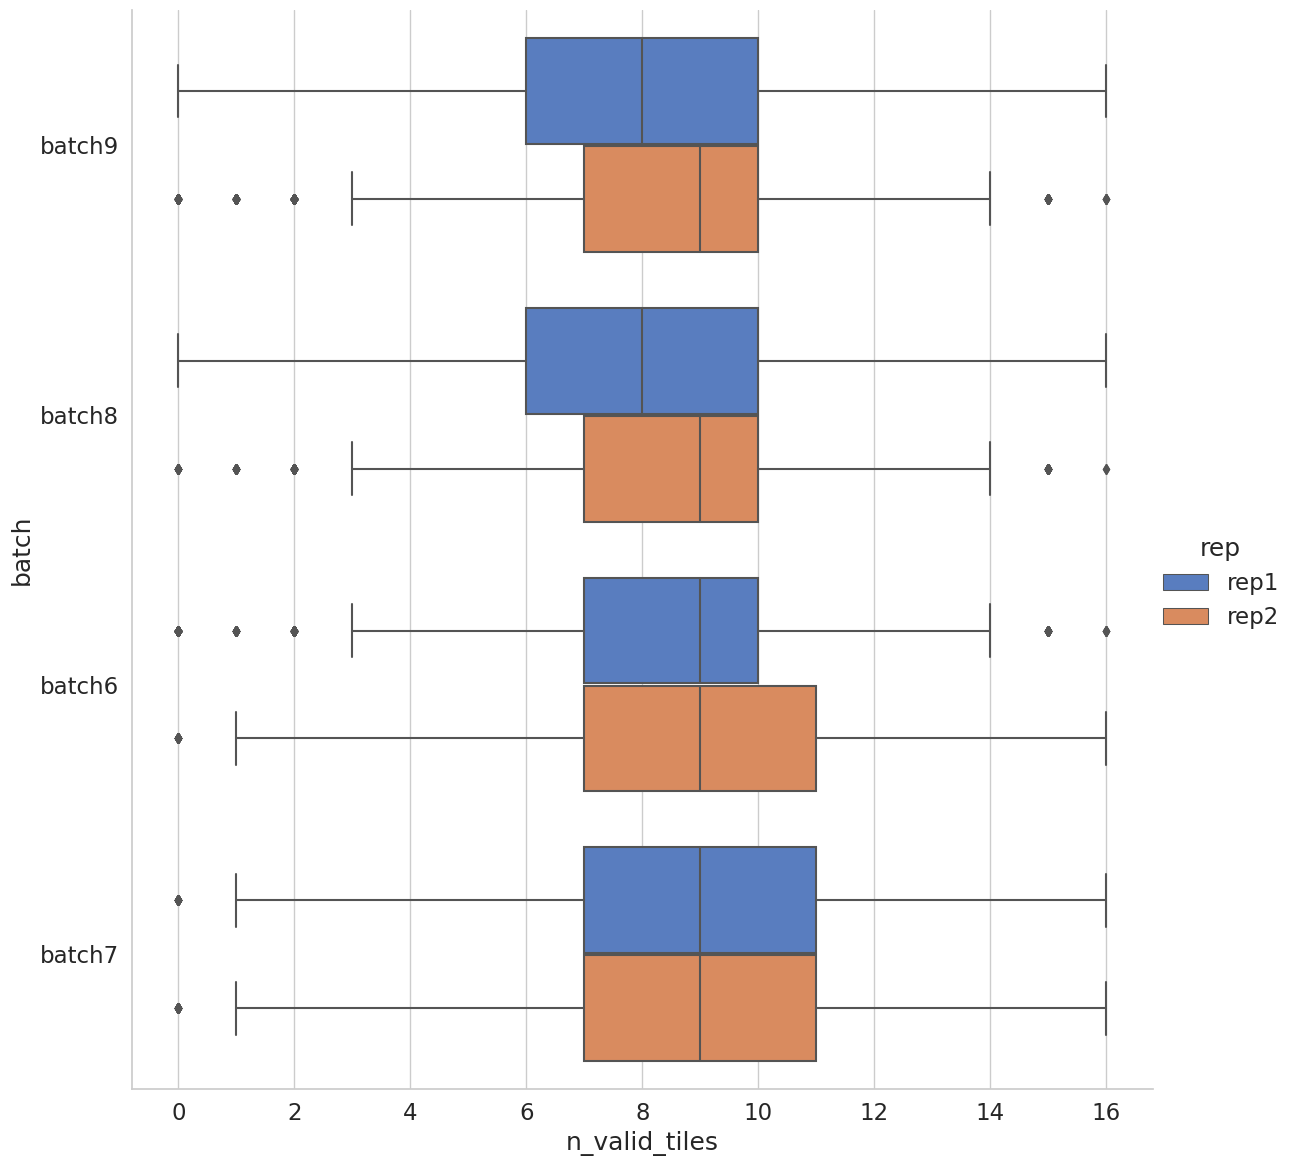

<Figure size 800x800 with 0 Axes>

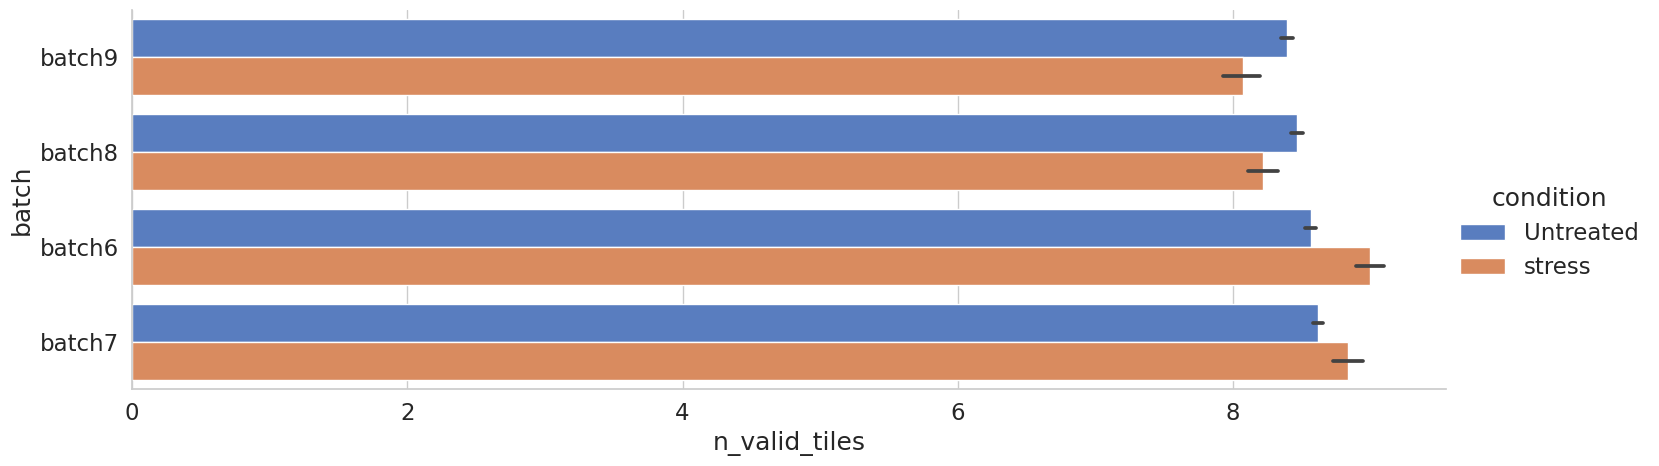

In [11]:
values = ['cells_count_mean', 'cells_count_std',
          'whole_cells_count_mean','whole_cells_count_std',
          'n_valid_tiles']

for value, c_palette in zip(values, ['pastel', 'husl', 'dark', 'deep', 'muted']):

    
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='box', data=df, y='batch', x=value, hue='rep', height=12, palette=sns.color_palette(c_palette))
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='bar', data=df, y='batch', x=value, hue='condition', aspect=3, palette=sns.color_palette(c_palette))




# <font color='grean'>Calc Statistics for valid tiles only (tiles that passed QC condition)  </font>



## <font color='purple'>Heatmap QC per batch, panel and cell line(tiles that passed QC condition)  </font>


/tmp/ipykernel_200420/1438628373.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))


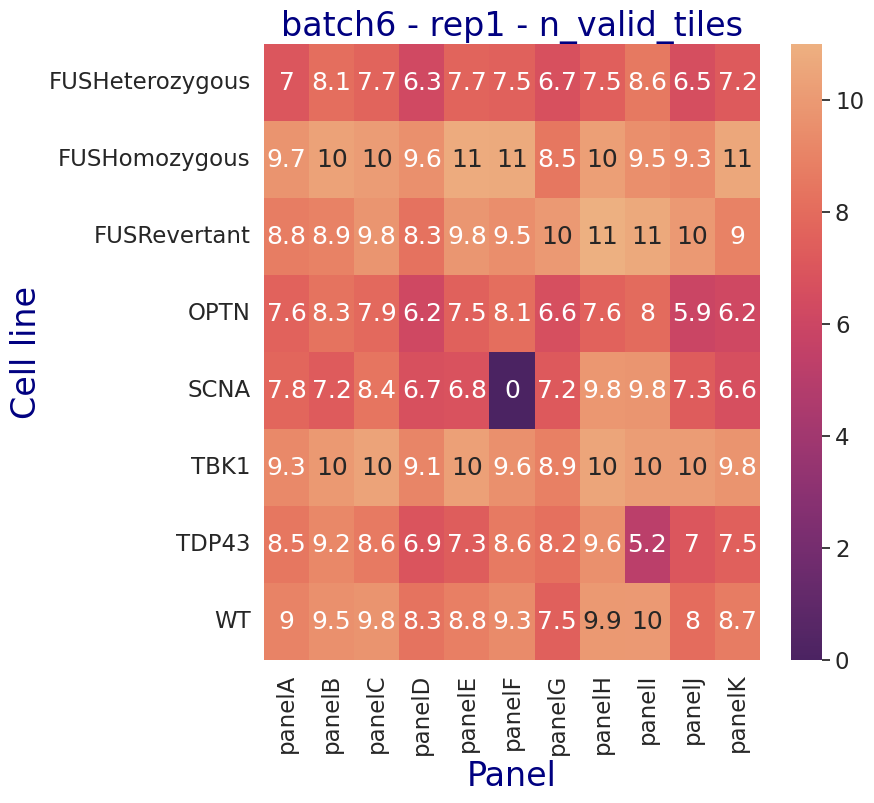

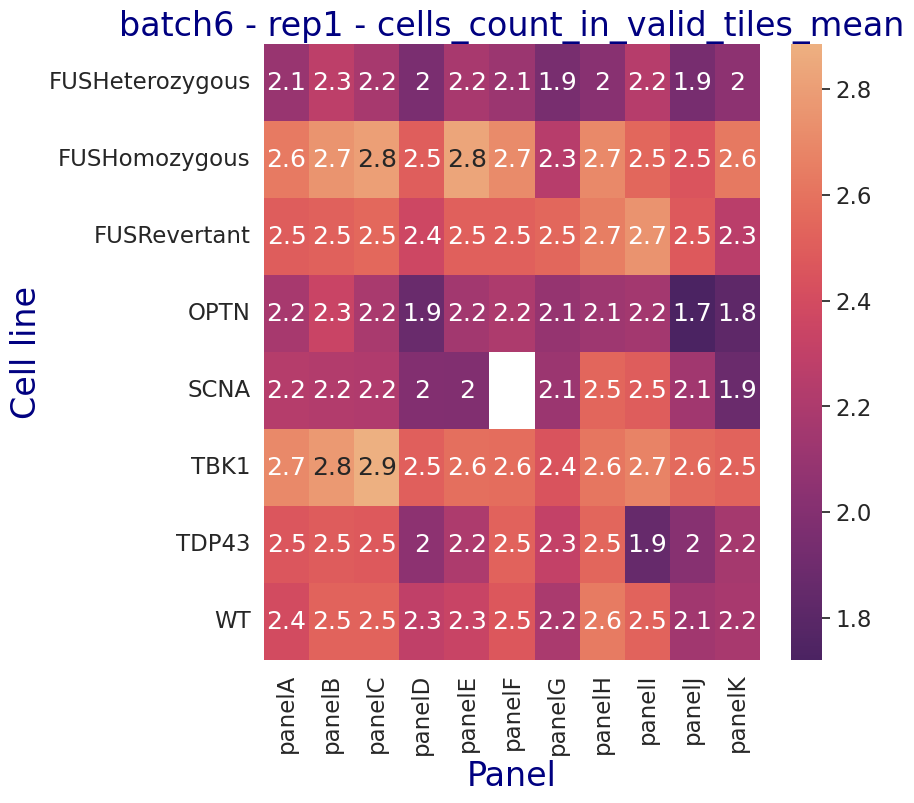

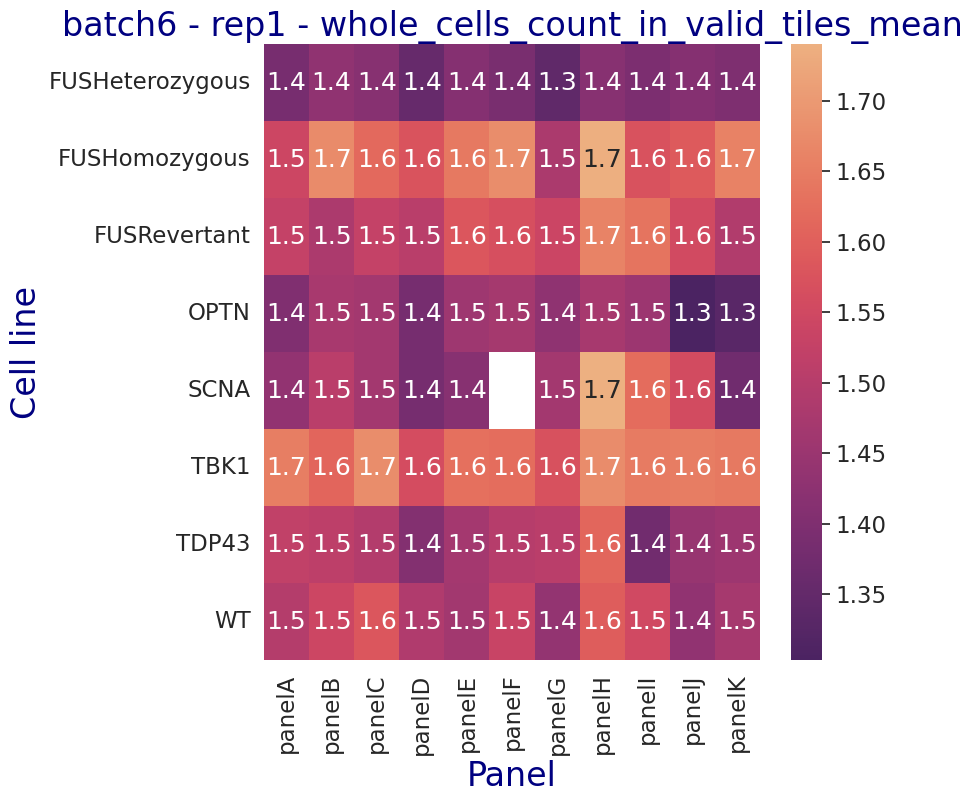

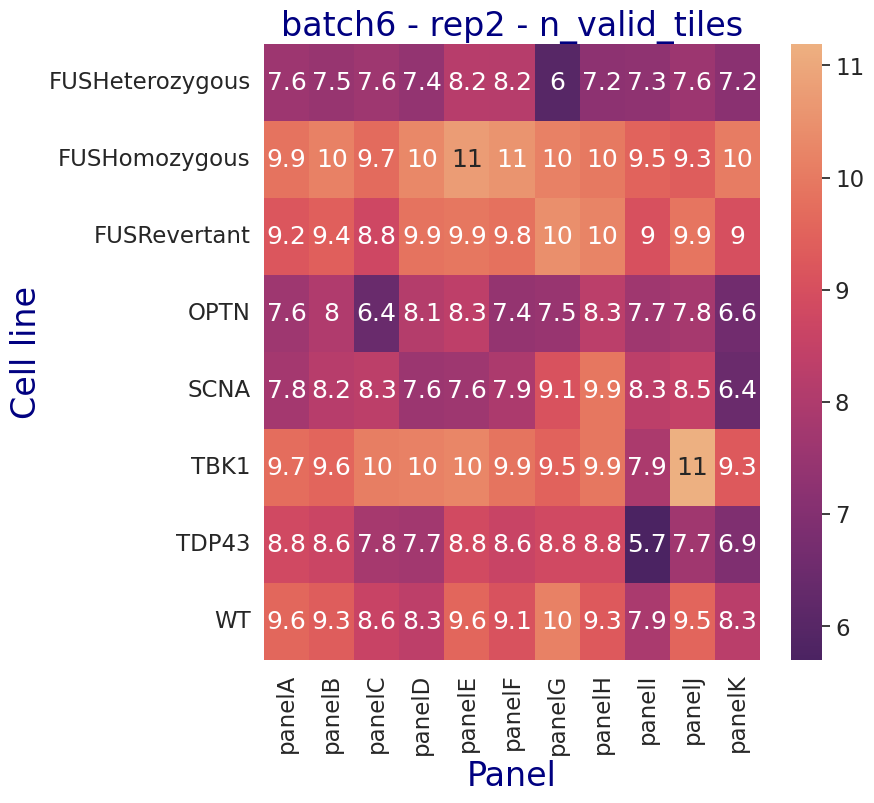

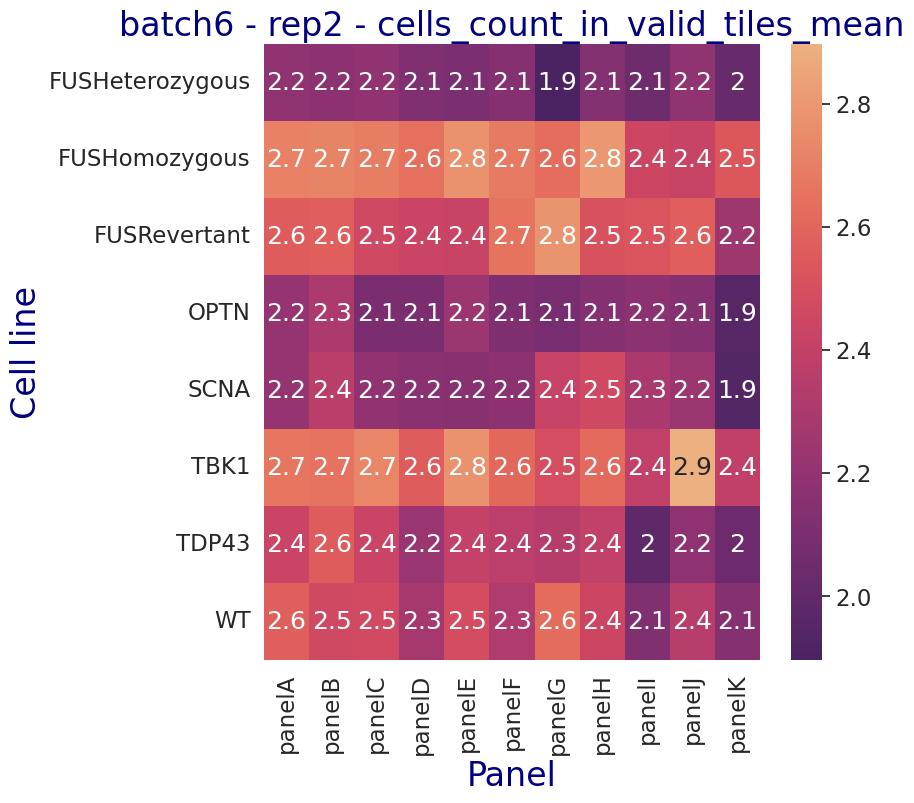

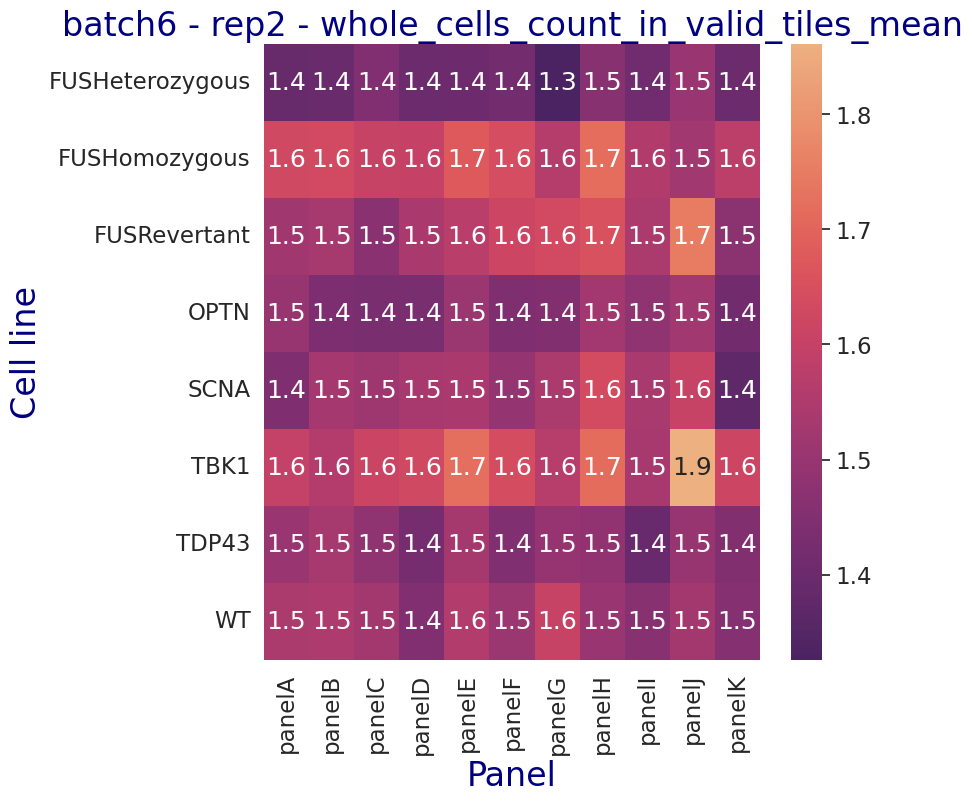

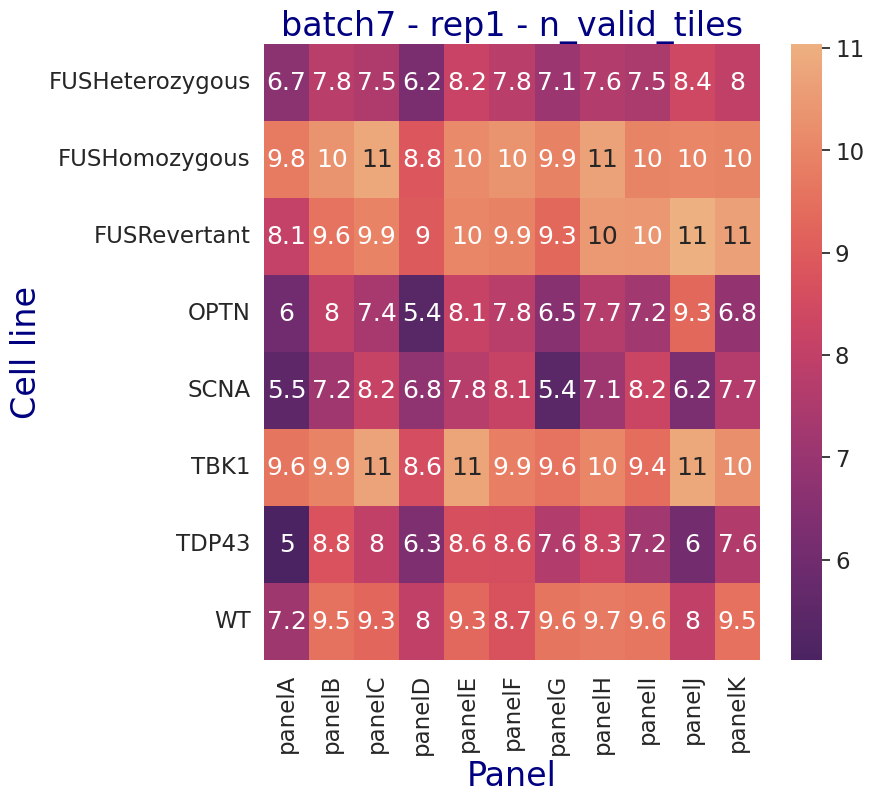

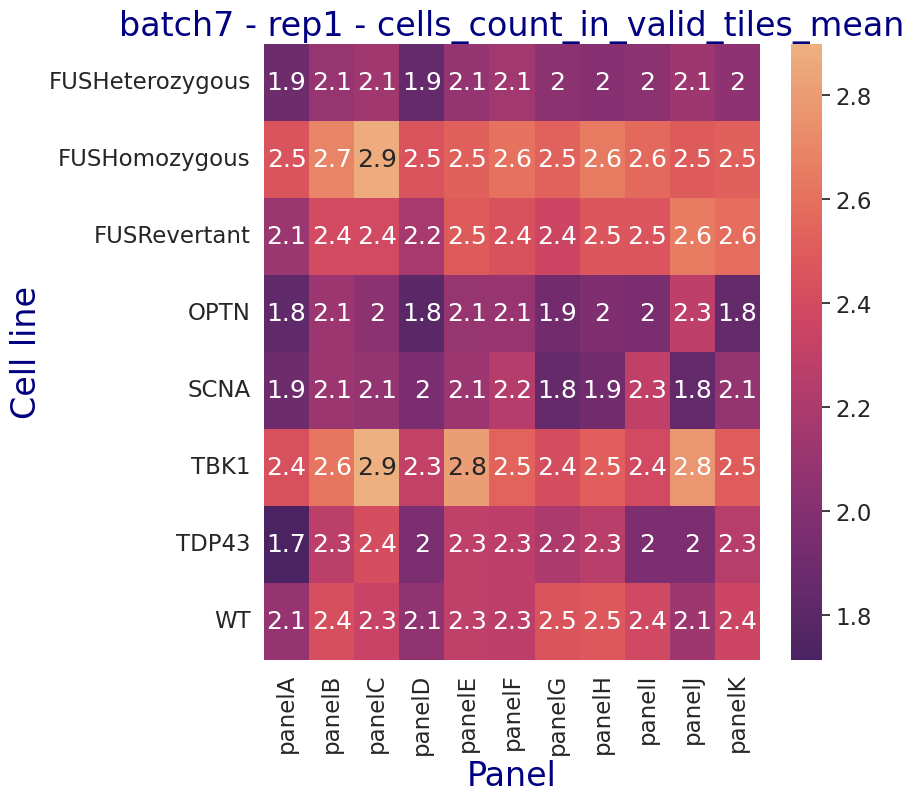

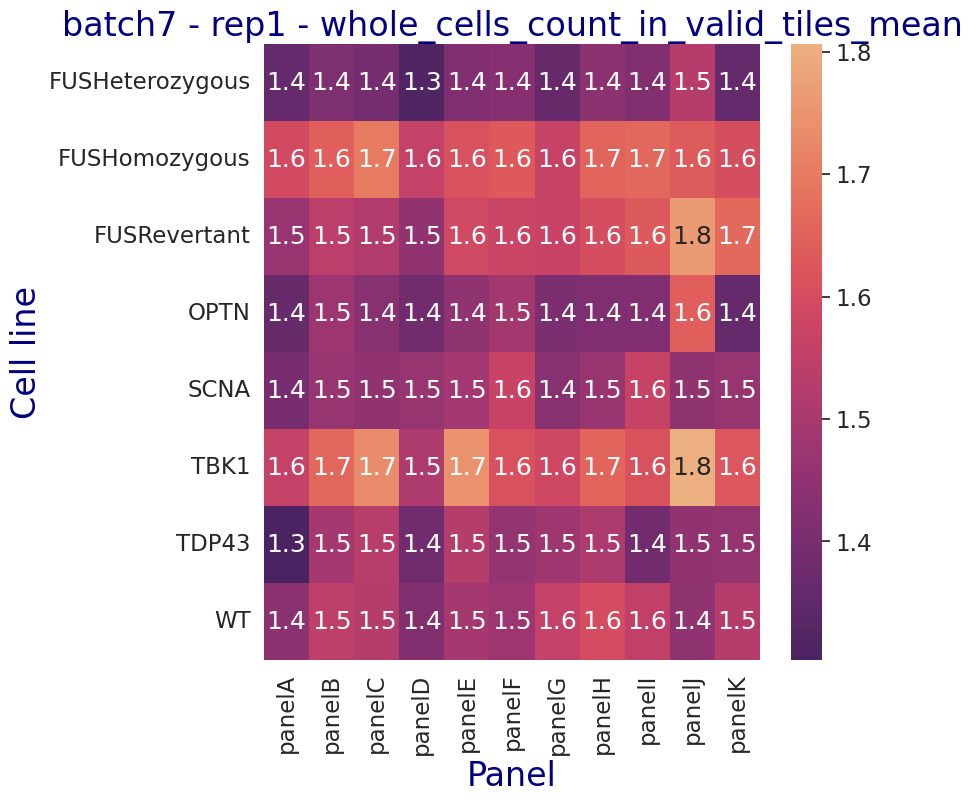

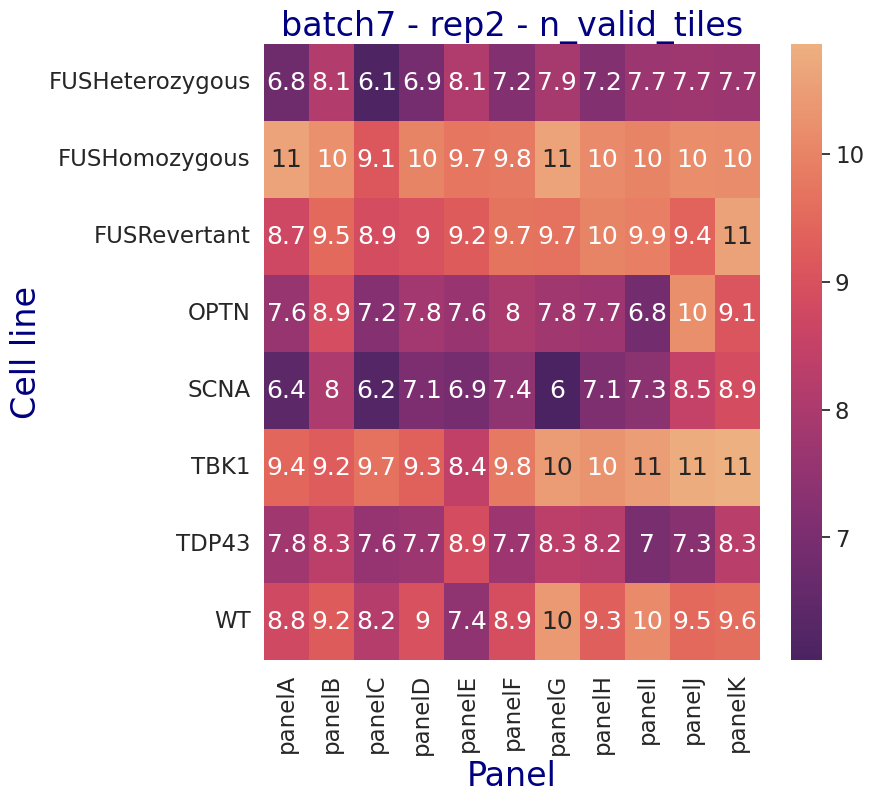

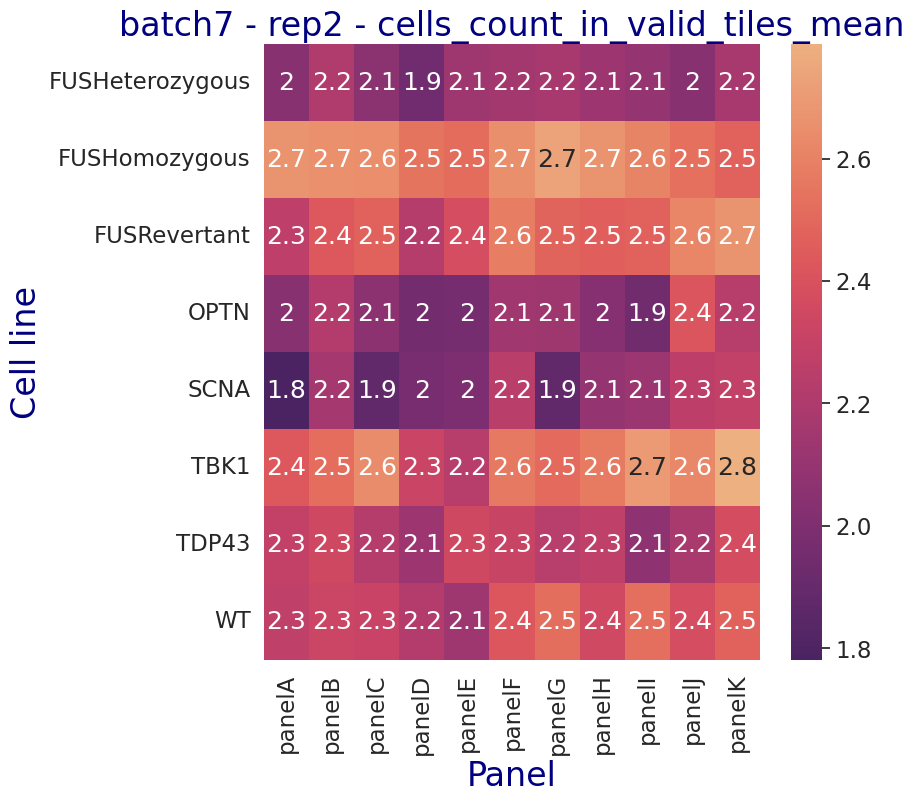

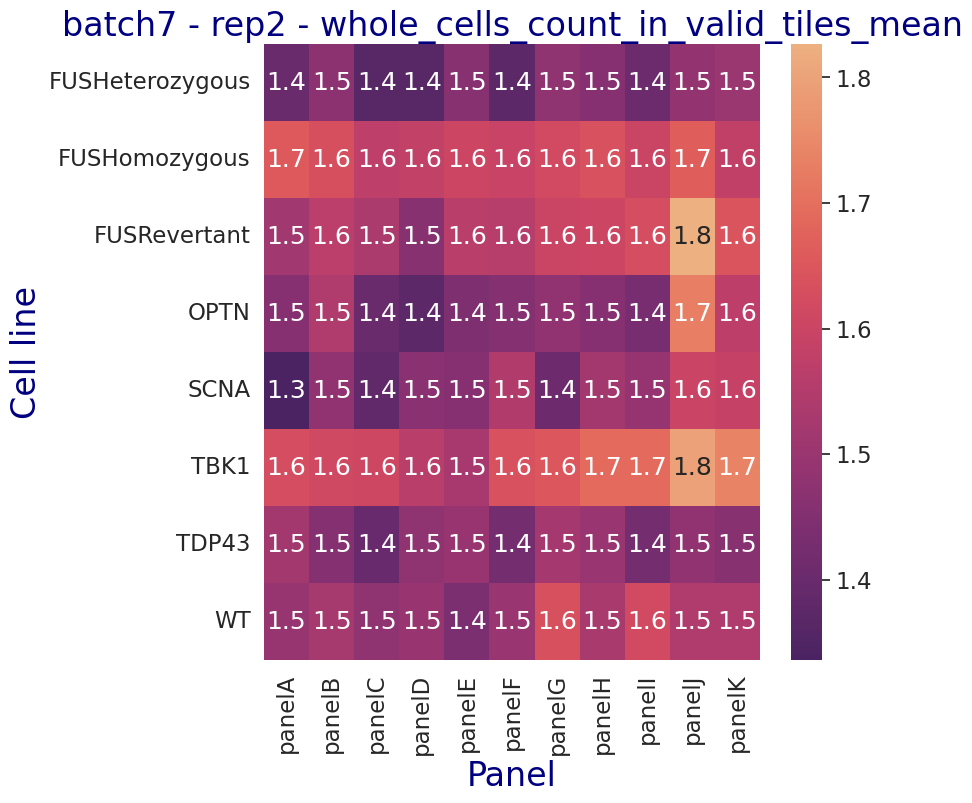

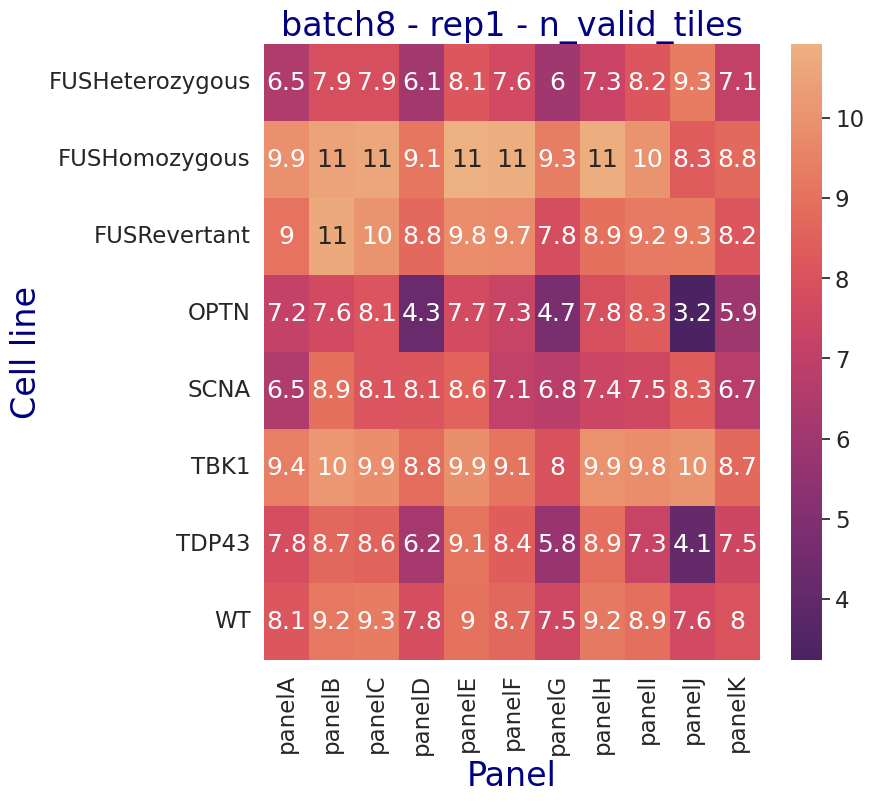

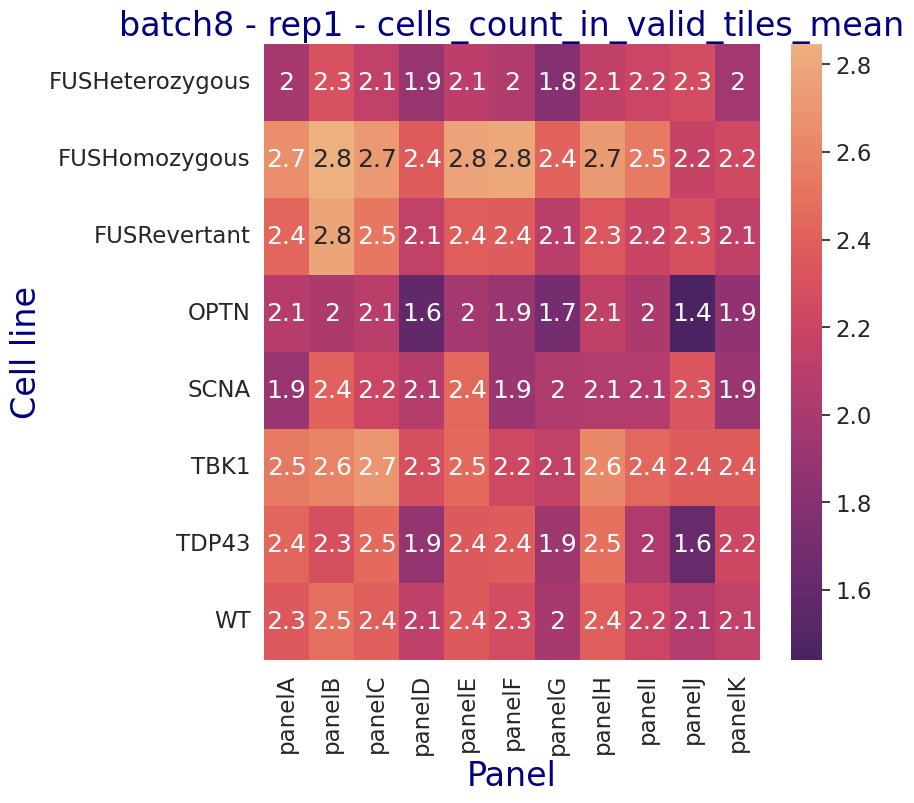

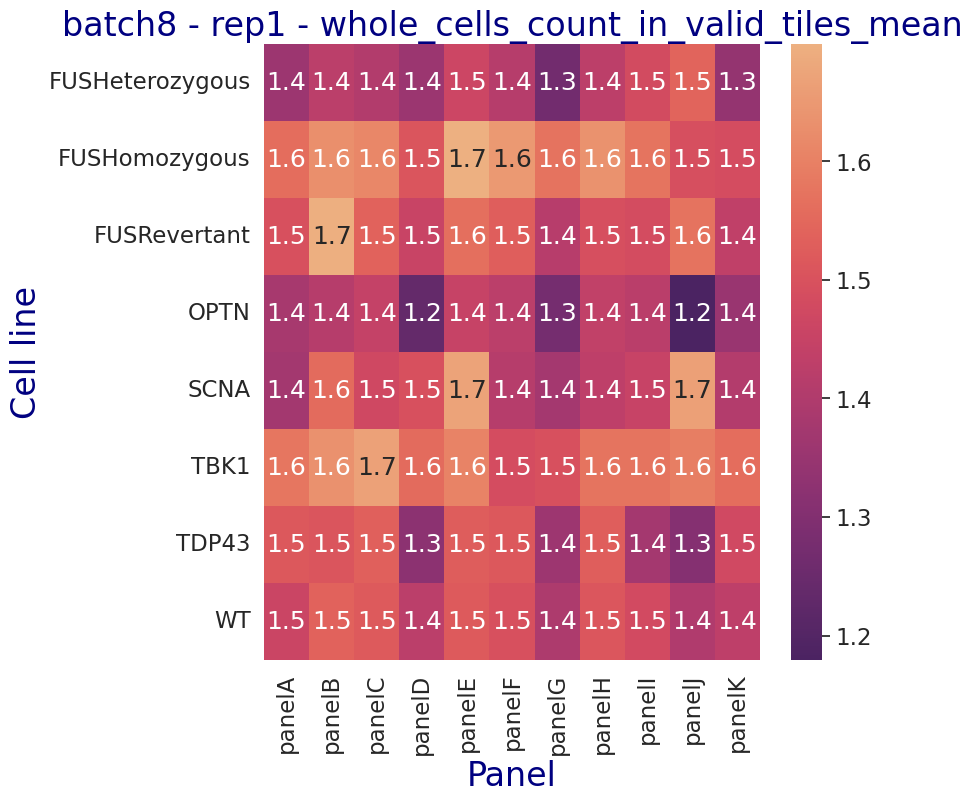

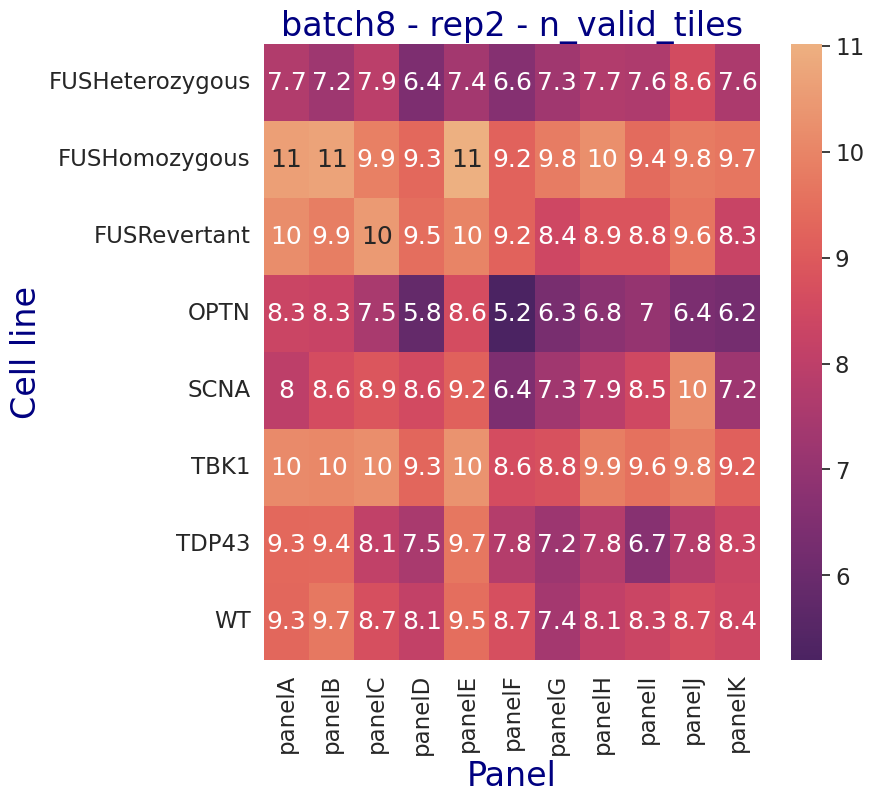

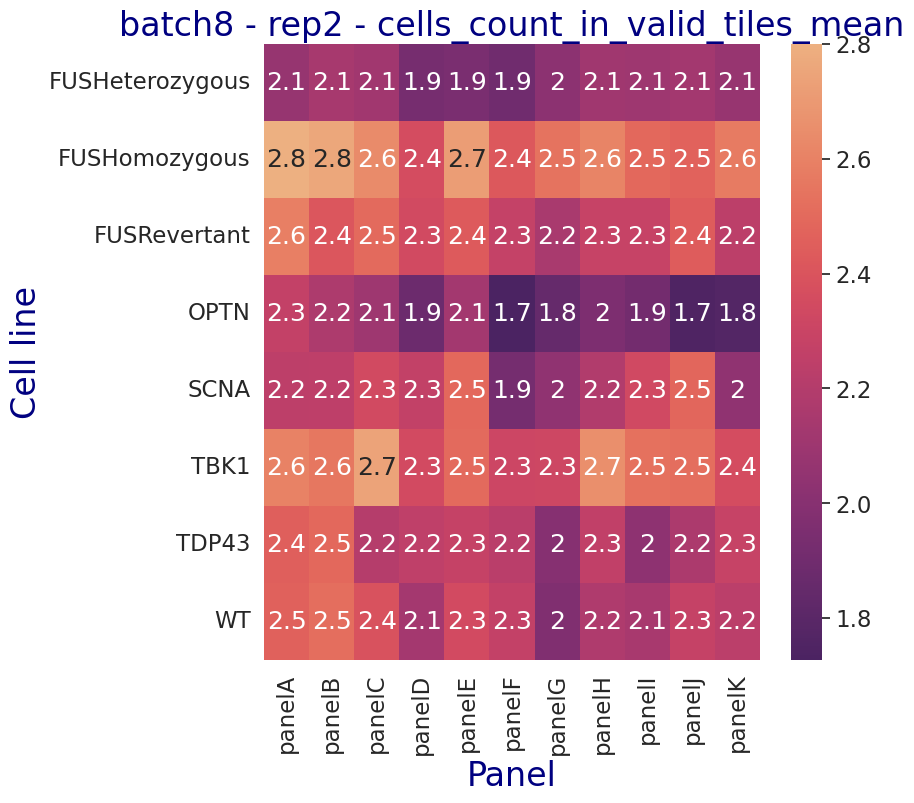

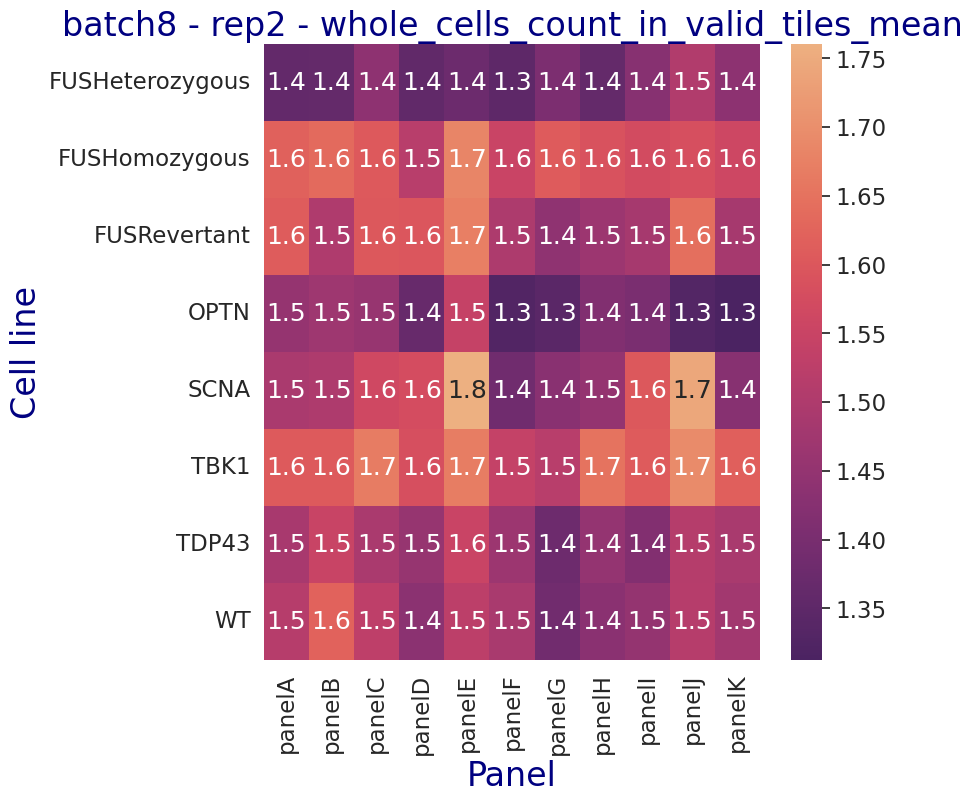

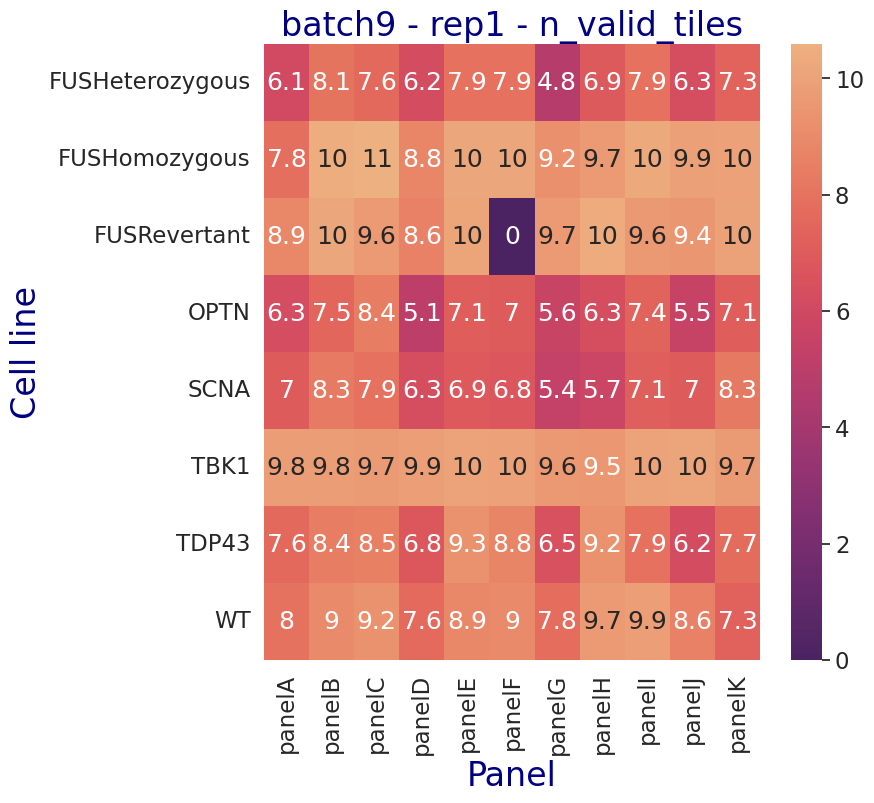

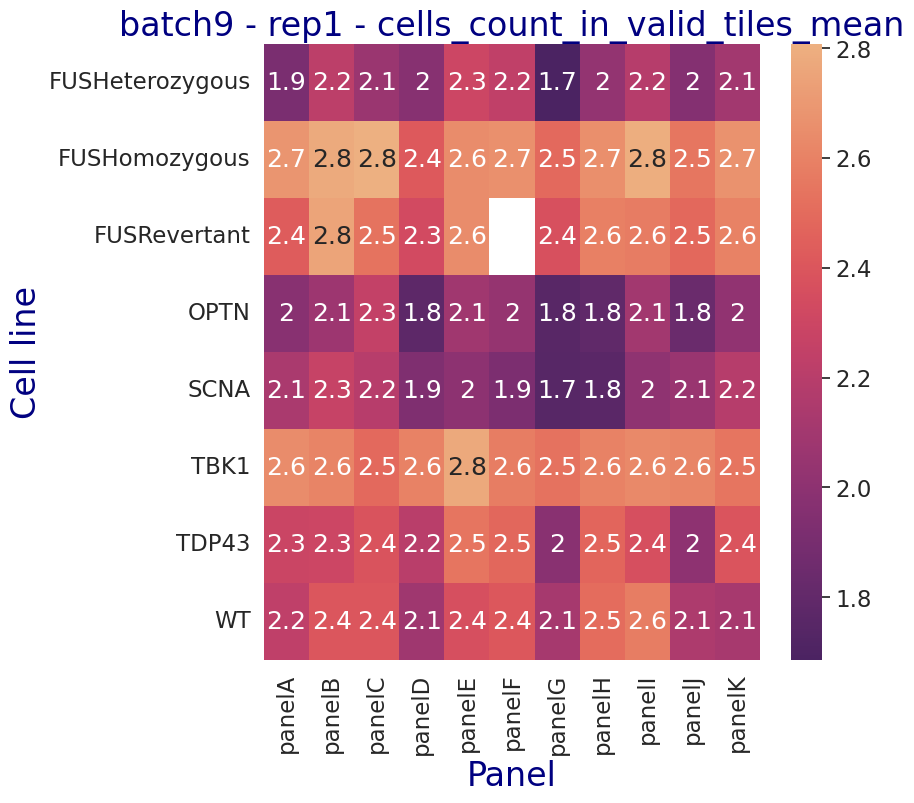

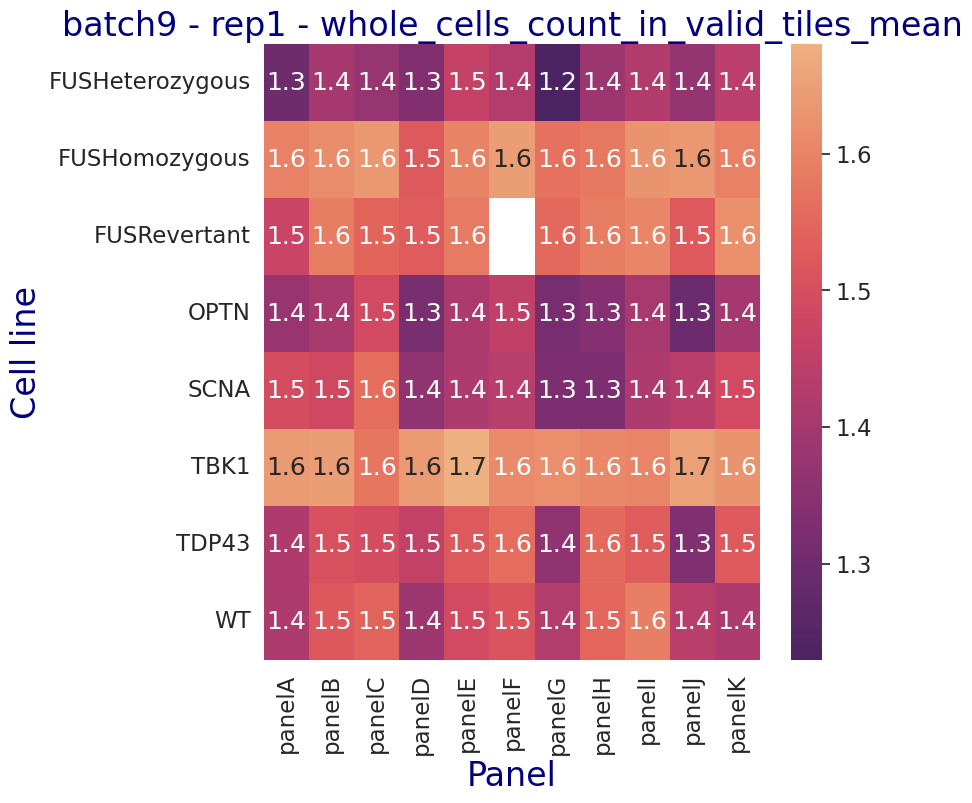

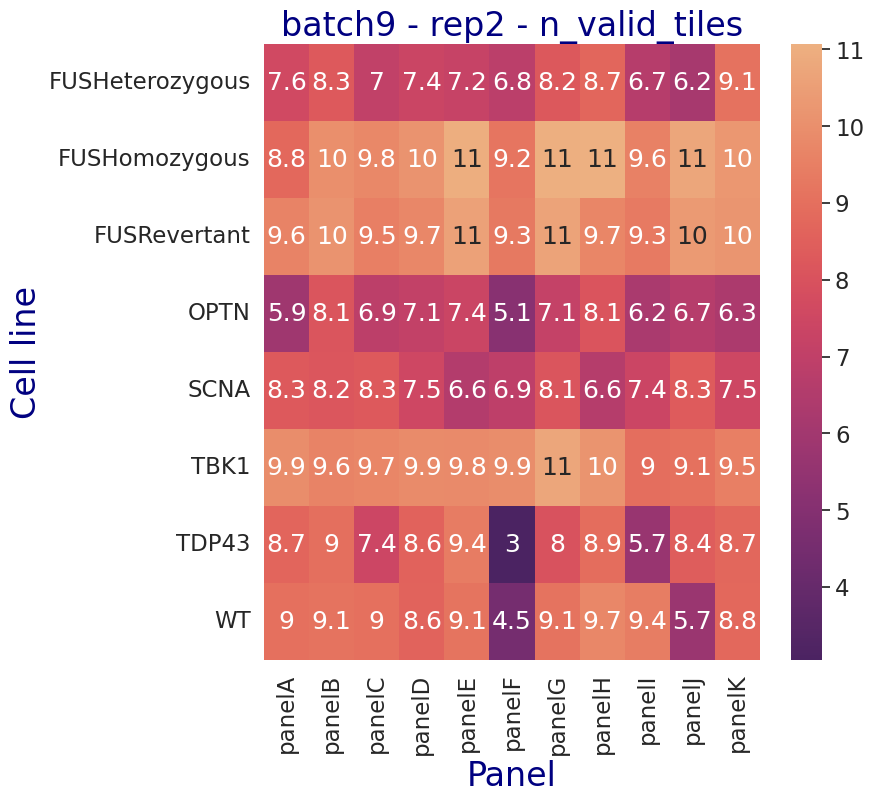

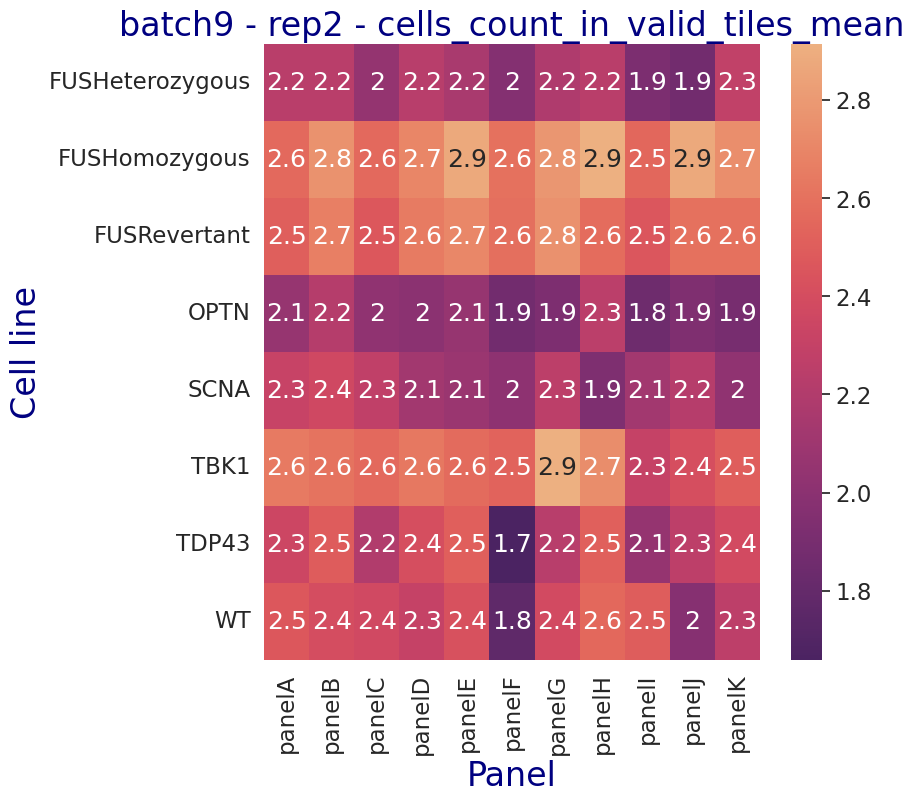

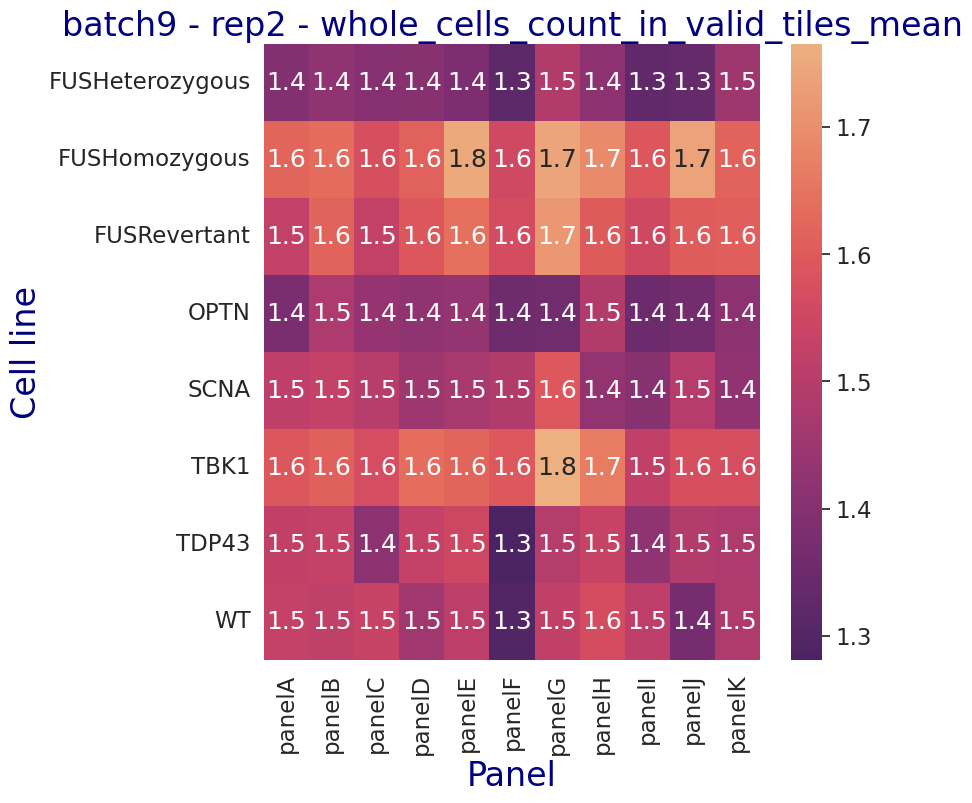

In [12]:
batchs = np.sort(df['batch'].unique())
reps = np.sort(df['rep'].unique())
for batch in batchs:
    for rep in reps:
        
        # Get relevant sub-set of the data
        df_batch = df[(df['batch']==batch) & ((df['rep']==rep))]
        
        for value in ['n_valid_tiles', 'cells_count_in_valid_tiles_mean', 'whole_cells_count_in_valid_tiles_mean']:

            plt.figure(figsize=(8,8))
            a = pd.crosstab(df_batch['cell_line'], df_batch['panel'], values=df_batch[value], aggfunc=np.mean)
            sns.heatmap(a, annot=True, cmap="flare_r")
            plt.title(batch + " - " + rep + " - " + value, fontsize=24, color="navy")
            plt.xlabel("Panel", fontsize=24, color="navy")
            plt.ylabel("Cell line", fontsize=24, color="navy")
        




<Figure size 800x800 with 0 Axes>

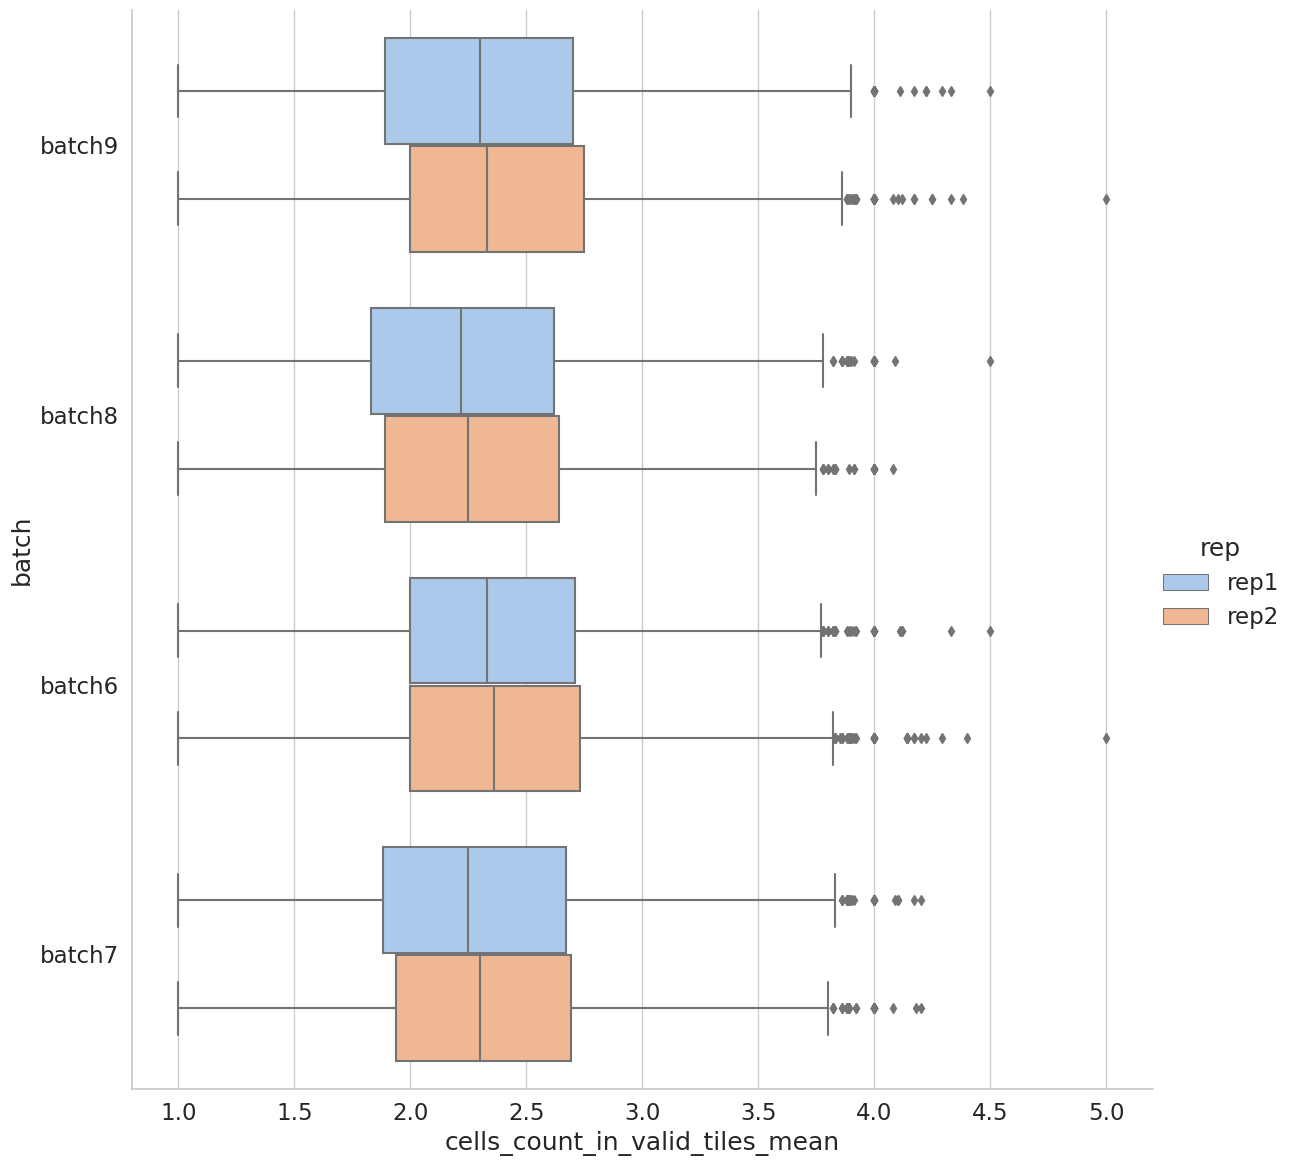

<Figure size 800x800 with 0 Axes>

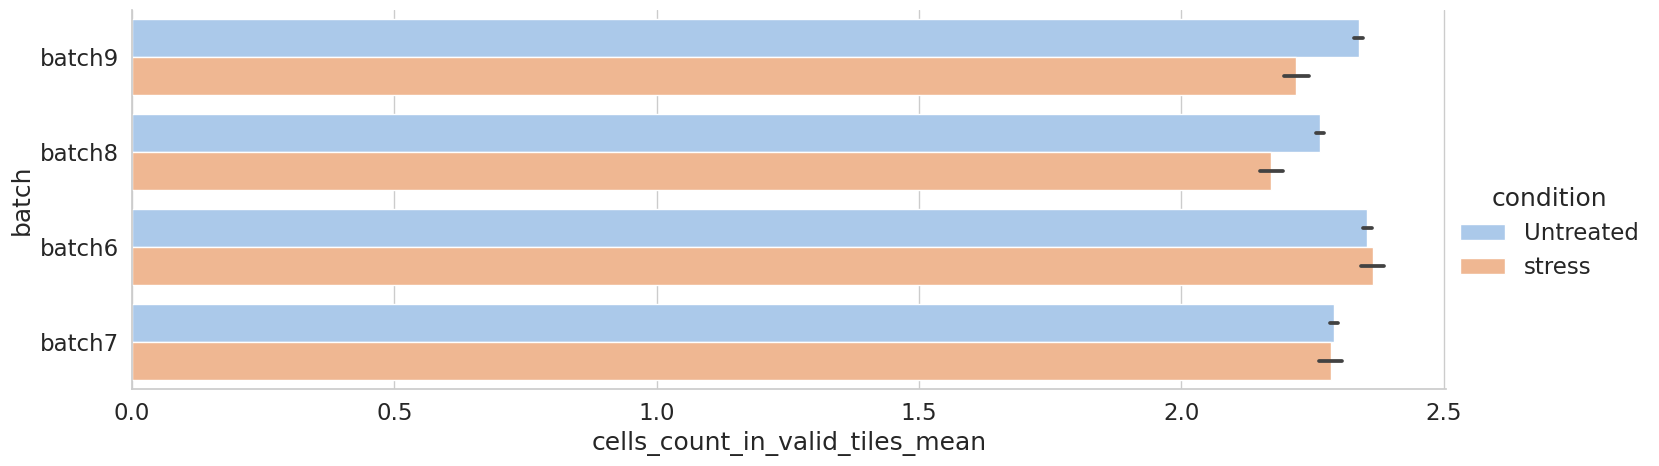

<Figure size 800x800 with 0 Axes>

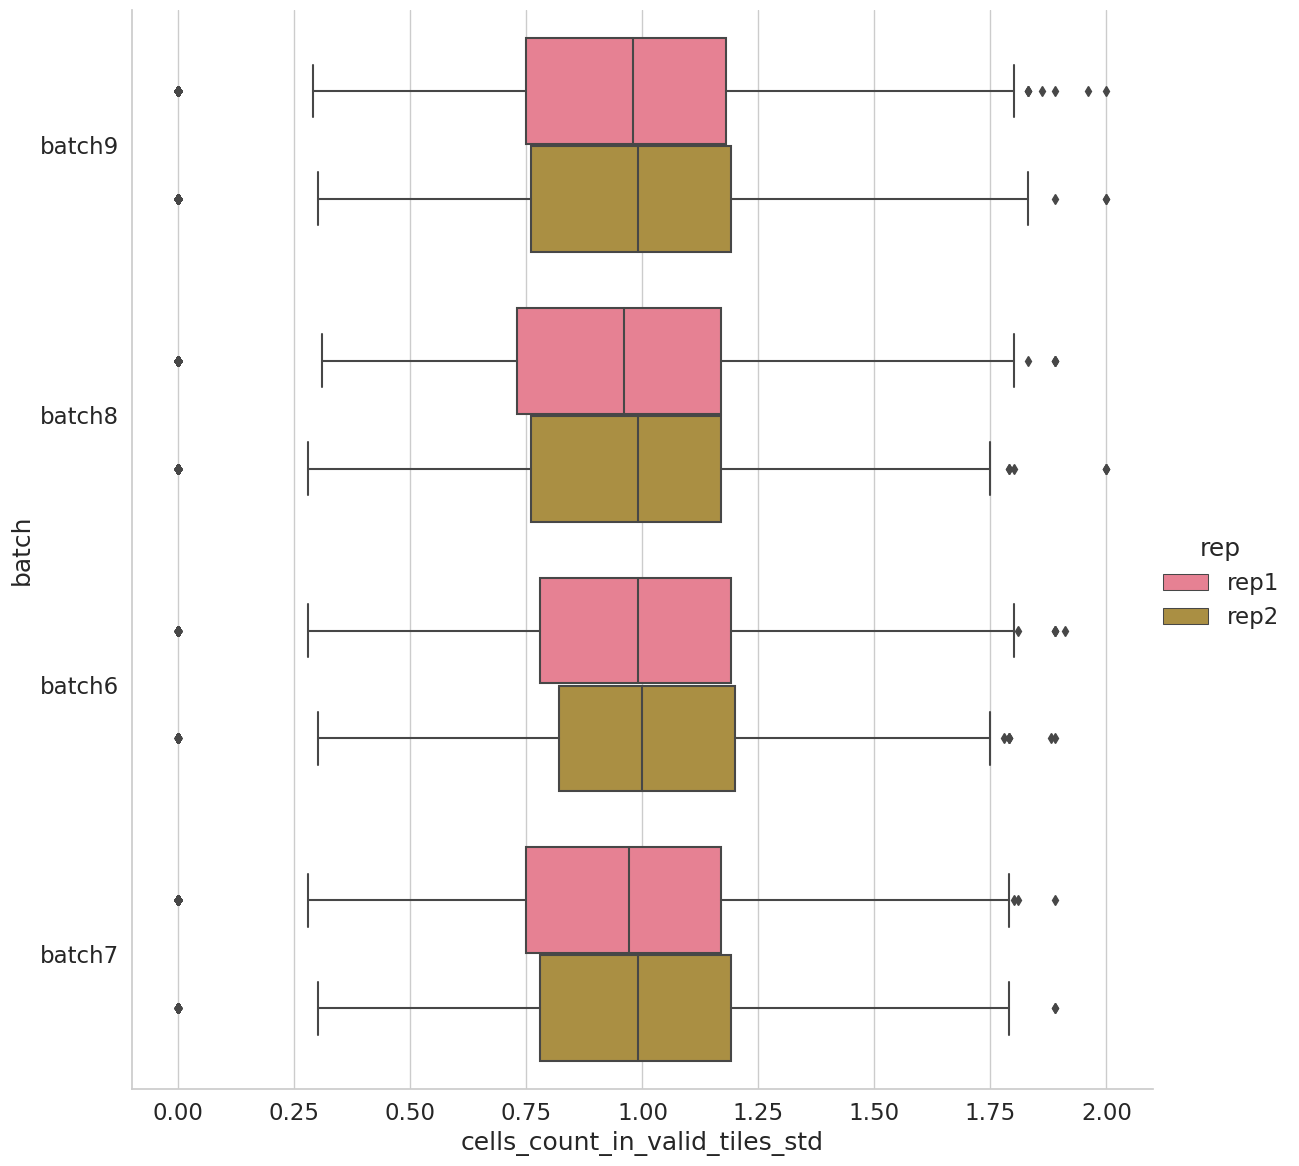

<Figure size 800x800 with 0 Axes>

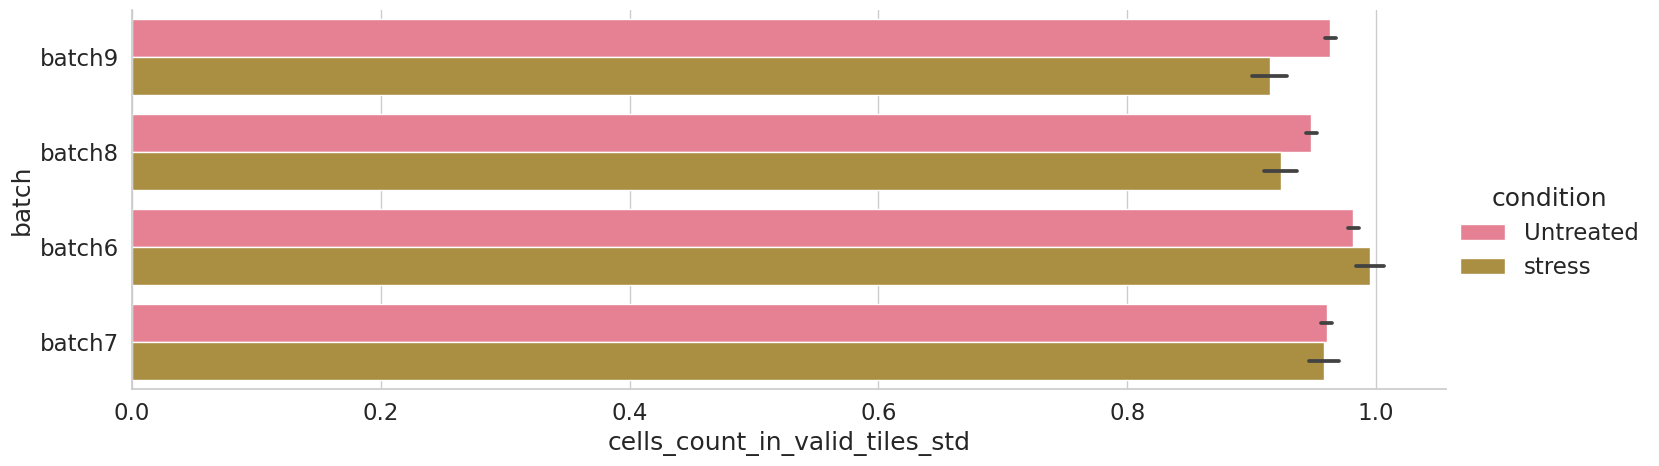

<Figure size 800x800 with 0 Axes>

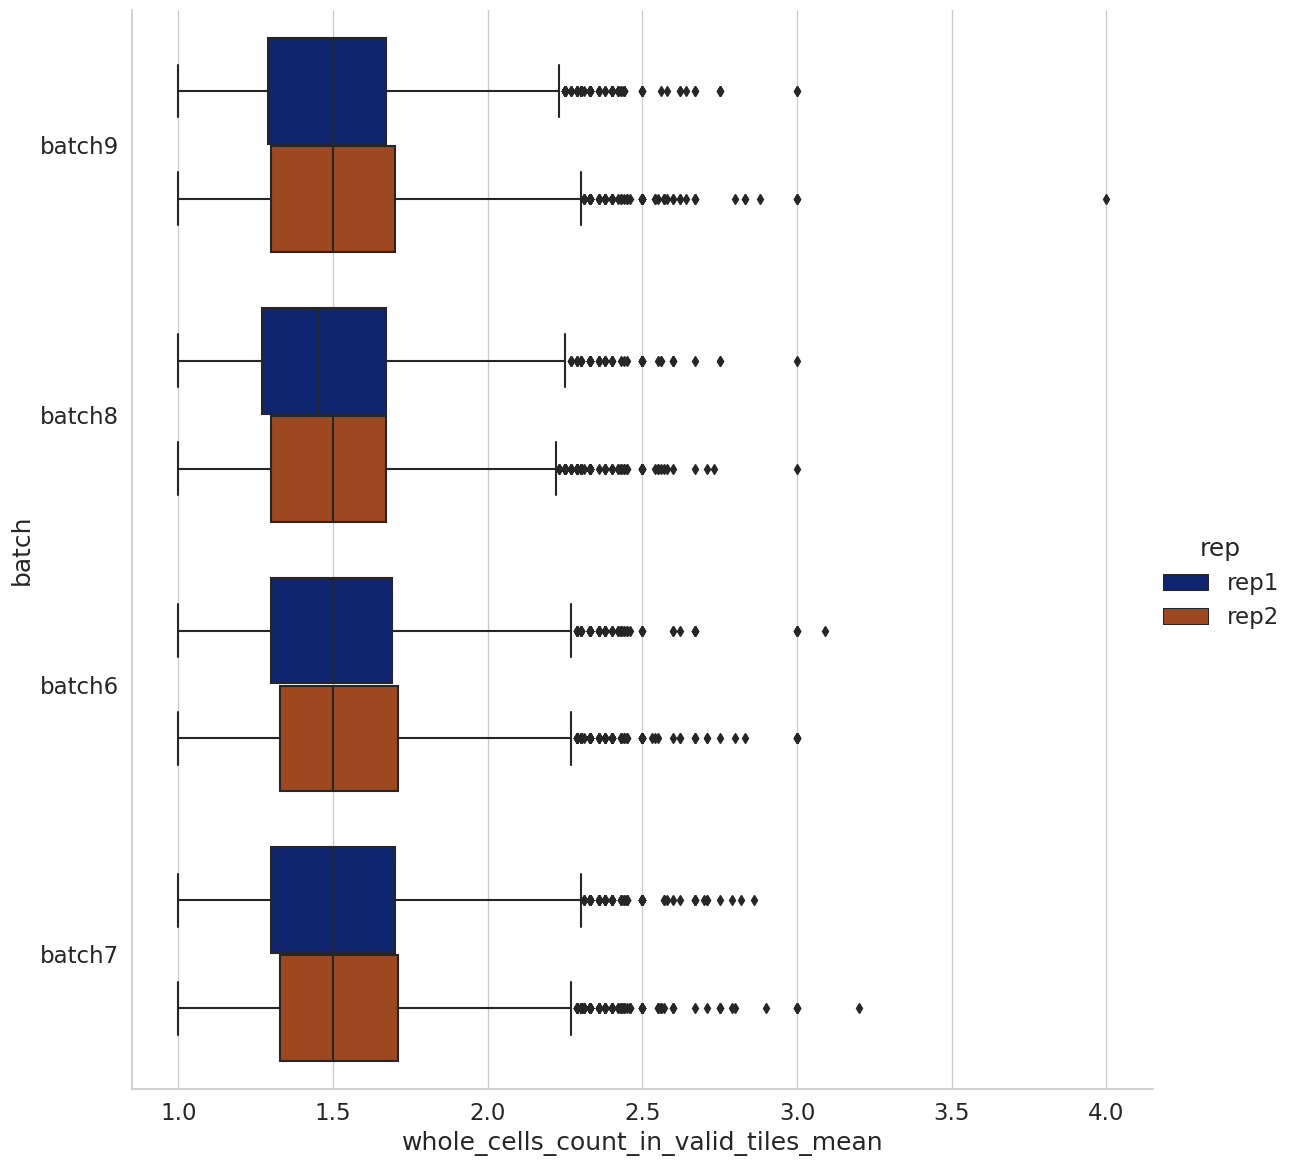

<Figure size 800x800 with 0 Axes>

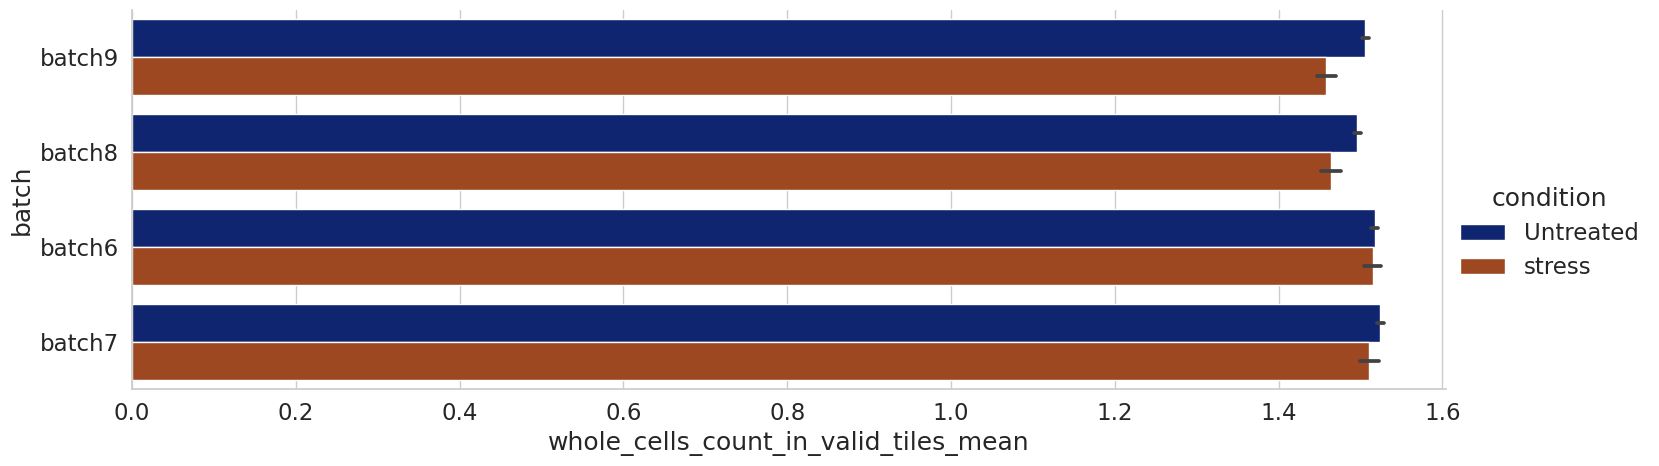

<Figure size 800x800 with 0 Axes>

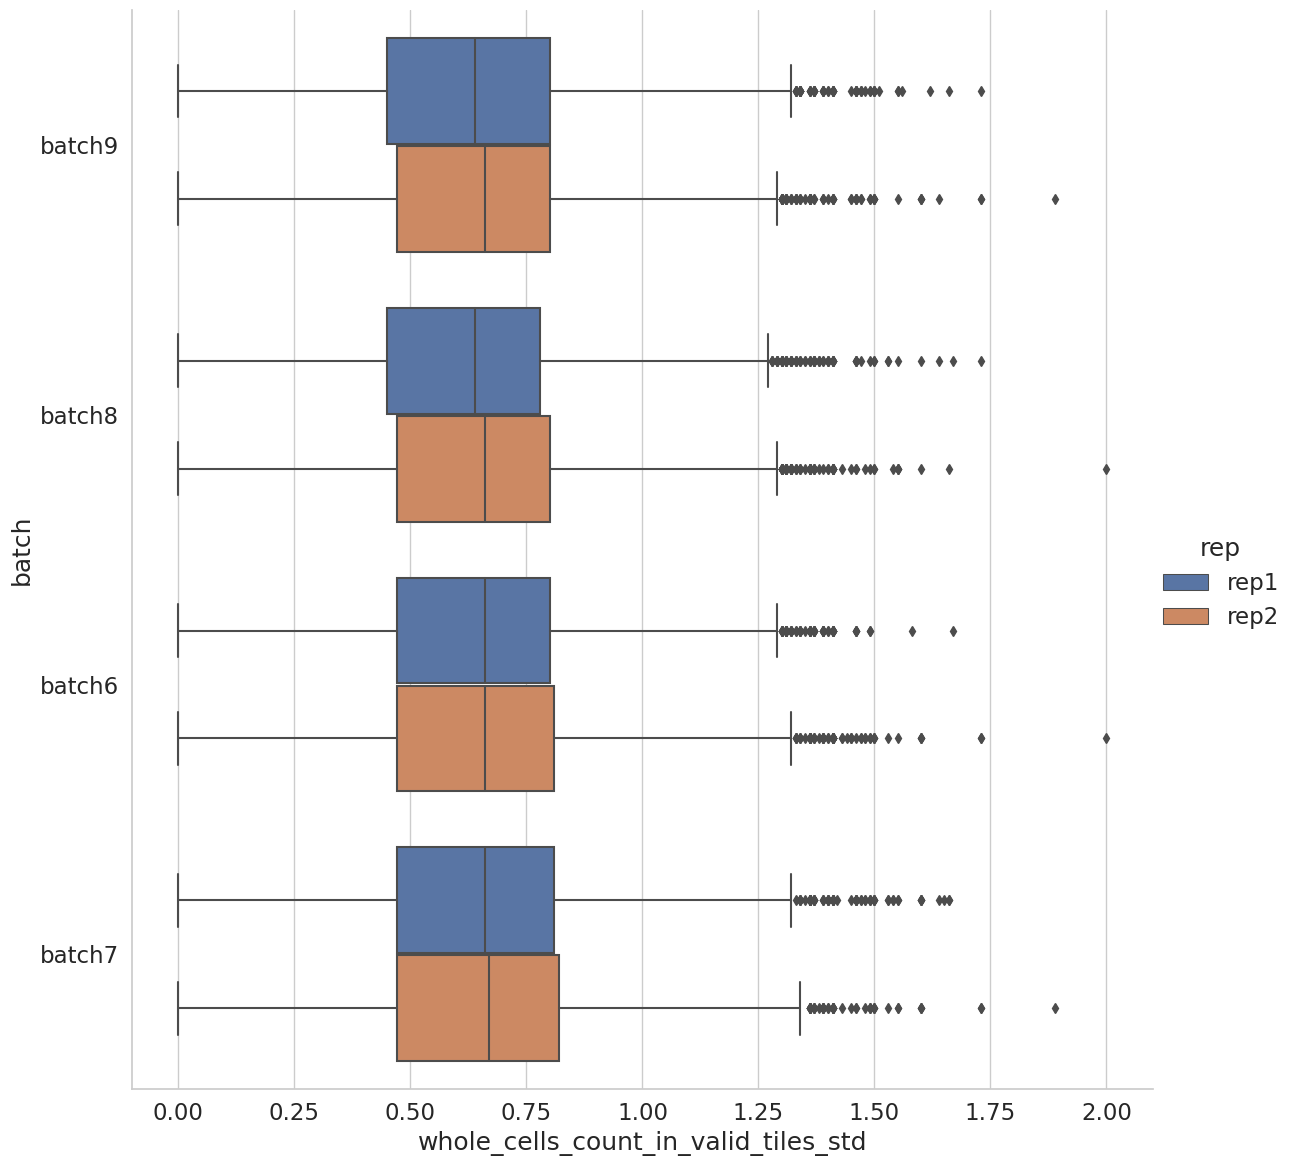

<Figure size 800x800 with 0 Axes>

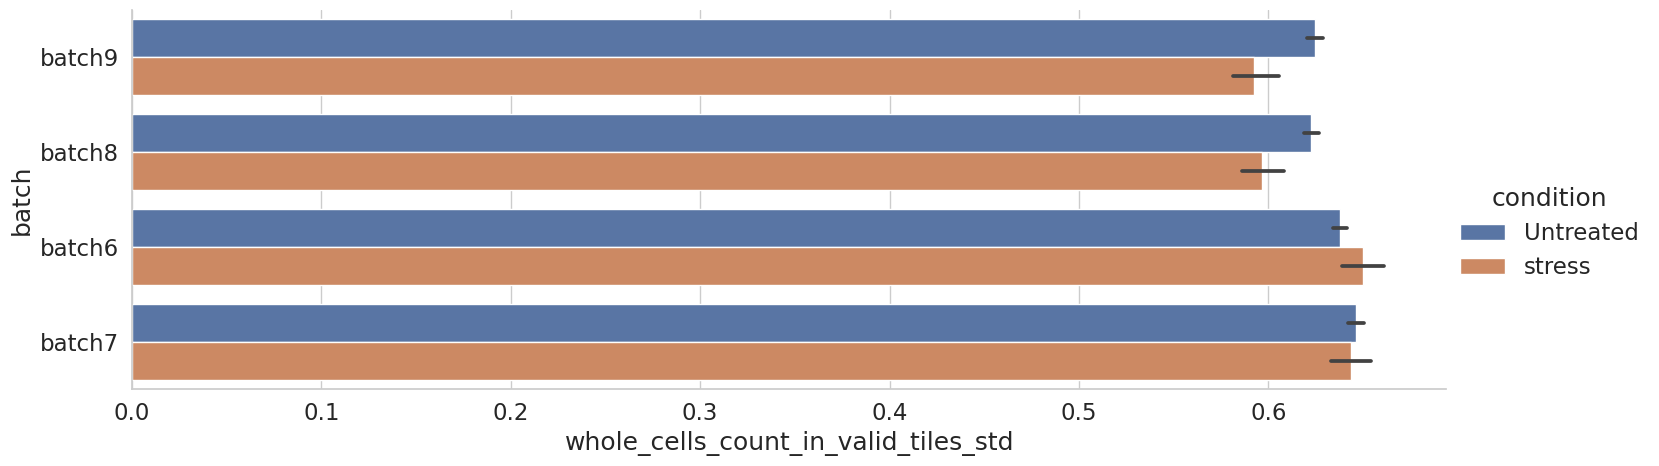

In [13]:
values = ['cells_count_in_valid_tiles_mean', 'cells_count_in_valid_tiles_std',
          'whole_cells_count_in_valid_tiles_mean','whole_cells_count_in_valid_tiles_std']

for value, c_palette in zip(values, ['pastel', 'husl', 'dark', 'deep', 'muted']):

    
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='box', data=df, y='batch', x=value, hue='rep', height=12, palette=sns.color_palette(c_palette))
    plt.figure(figsize=(8,8))
    p = sns.catplot(kind='bar', data=df, y='batch', x=value, hue='condition', aspect=3, palette=sns.color_palette(c_palette))



In [14]:
##print(df.groupby(['batch'])['whole_cells_count_in_valid_tiles_mean'].mean())
##print(df.groupby(['cell_line'])['whole_cells_count_in_valid_tiles_mean'].mean())
##print(df.groupby(['batch','cell_line'])['whole_cells_count_in_valid_tiles_mean'].mean())


In [15]:
# save notebook as HTML ( the HTML will be saved in the same folder the original script is)
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
os.system('jupyter nbconvert --to html cell_count_stats_analysis.ipynb')

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook cell_count_stats_analysis.ipynb to html
[NbConvertApp] Writing 5719296 bytes to cell_count_stats_analysis.html


0

In [16]:

print("Done!")

Done!


In [17]:

#mask = df['batch']=='batch3'
#mask2 = df['marker']!='DAPI'
#df[mask & mask2].shape